# The Response of Sea Surface Temperature to Rain

Newly revised notebook of code 6/22/22

In [13]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as datetime
import glob
import scipy
import tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import matplotlib.dates as mdates
#%matplotlib inline
import gsw
import metpy
from subprocess import Popen, PIPE
from time import sleep
import os
from dateutil import parser

import matlab.engine

#from scipy.signal import find_peaks
from scipy.io import loadmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Data Import

In [14]:
# import R/V Revelle data 
revelle_datapath = '../Data/Level_3/Dynamo/Revelle_FluxData/Revelle_All_Legs_r4.cdf'
rv = xr.open_dataset(revelle_datapath)

# import MJO phase & add to Revelle dataset
mjo = pd.read_csv('../Data/Level_0/MJO phase/rmm.74toRealtime.txt', sep='\s+',skiprows=2,parse_dates=[[0,1,2]],index_col=0,
                   names=['year','month','day','RMM1','RMM2','phase','amplitude'],usecols=[0,1,2,3,4,5,6]).loc[slice(rv.index[0].values,rv.index[-1].values)]
rv['mjo_phase'] = mjo.phase.to_xarray().rename({'year_month_day':'index'}).interp_like(rv,method='nearest')

#import COARE rain heat flux output as a dictionary of numpy arrays using the scipy loadmat function
SHFr_Leg1 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_rainAdjusted_Leg1_r4.mat')
SHFr_Leg2 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_rainAdjusted_Leg2_r4.mat')
SHFr_Leg3 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_rainAdjusted_Leg3_r4.mat')
SHFr_Leg4 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_rainAdjusted_Leg4_r4.mat')
SHFr = np.concatenate((SHFr_Leg1['SHF_rain'][0,:],SHFr_Leg2['SHF_rain'][0,:],SHFr_Leg3['SHF_rain'][0,:],SHFr_Leg4['SHF_rain'][0,:]))

SSTr_Leg1 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjusted_Leg1_r4.mat')
SSTr_Leg2 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjusted_Leg2_r4.mat')
SSTr_Leg3 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjusted_Leg3_r4.mat')
SSTr_Leg4 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjusted_Leg4_r4.mat')
SSTr = np.concatenate((SSTr_Leg1['SSTB'][0,:],SSTr_Leg2['SSTB'][0,:],SSTr_Leg3['SSTB'][0,:],SSTr_Leg4['SSTB'][0,:]))

SSTr_bulk = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjustedFROMBULK_ALLLEGS.mat')['SST'][0,:]
SST_bulk = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_baseCOARE_FROMBULK_ALLLEGS.mat')['SST'][0,:]

SHF_fromBulk = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_baseCOARE_fromBulk_AllLegs.mat')['shf'][0,:]
SHF_fromSkin = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_baseCOARE_fromKT15_AllLegs.mat')['shfC'][0,:]

rv = rv.assign({'SSTrain': xr.DataArray(SSTr,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SSTrain_fromBulk': xr.DataArray(SSTr_bulk,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SST_fromBulk': xr.DataArray(SST_bulk,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SHFrain': xr.DataArray(SHFr,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SHF_fromBulk': xr.DataArray(SHF_fromBulk,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SHF_fromSkin': xr.DataArray(SHF_fromSkin,dims='index',coords={'index':rv.index})})

# import DC fluxes and add to Revelle dataset
#load file as a dictionary of numpy arrays using the scipy loadmat function
Edson_raw = loadmat('../Data/Level_1/Dynamo/DC Fluxes From Edson (with closed path)/Transfer_D05.mat')
#drop the metadata keys from the dictionary so that all the remaining arrays are the same size
del Edson_raw['__header__']
del Edson_raw['__version__']
del Edson_raw['__globals__']
del Edson_raw['D']
del Edson_raw['zi']
del Edson_raw['zq']
del Edson_raw['zt']
del Edson_raw['zu']
del Edson_raw['cpa']
del Edson_raw['lstatchk']
del Edson_raw['uklMeas']
del Edson_raw['uklsave']
year = 2011
date = datetime.datetime(year, 1, 1) + pd.to_timedelta(Edson_raw['yday'][0]-1,unit='days')
Edson_Fluxes = pd.DataFrame(index=date)
#iterate over each key in the dict and add to the pandas dataframe as a new column
for key in Edson_raw:
    #print(key)
    Edson_Fluxes[key] = Edson_raw[key][0].tolist()
Edson_Fluxes = Edson_Fluxes.to_xarray()

#interpolate coare outputs onto DC timestamps
Edson_Fluxes['Hl_bulk'] = rv.lhf.interp_like(Edson_Fluxes,method='linear')

#calculate closed-path sensible heat flux
ρ = Edson_Fluxes.rhoair #[kg/m^3]
LE = 2260               #[kJ/kg]
q = Edson_Fluxes.Qair   #[g/kg]
T = Edson_Fluxes.Tair + 273.15   #[C] -> [K]
wTs = Edson_Fluxes.WTr  #[m/s K]

#calculate w'q' from COARE Latent Heat Flux output
wq = Edson_Fluxes.Hl_bulk/ρ/LE/1000

#calculate Sensible Heat Flux
wT = (wTs - 0.518*T*wq) / (1 + 0.518*(q/1000))   # ( [m/s K] - [K][m/s][g/g] ) / [g/g] ) -> [m/s][K]
cp = 1.005 + 1.82*(q/1000) #[J/g K]
HsC = ρ*cp*wT*1000 
Edson_Fluxes['HsC'] = HsC

rv['HsC'] = Edson_Fluxes.HsC.interp_like(rv,method='linear')
#rv

In [15]:
#import SST data
kt_dynamo = xr.open_dataset('../Data/Level_3/Dynamo/KT15_WarmCal/Dynamo_KT15_CalibratedSST_v2.cdf')
#sort dataset into sequential timesteps
kt_dynamo = kt_dynamo.sortby(kt_dynamo.index)
#resample SST to 10 second mean
kt_10s = kt_dynamo.SST.resample(index='10s').mean()

In [16]:
#add KT-15 to rv dataset and compute gradient variables Tskin-Tair and Qsat(Tskin)-Qair
rv['sst_skin'] = kt_10s.rolling(index=6).mean().interp_like(rv,method='linear')
rv['ΔT_skin_air'] = rv.sst_skin - rv.T02

T = rv.sst_skin #C
P = rv.Pair10 #mbar

saturation_vapor_pressure = 6.112*np.exp(17.67*T/(T+243.5)) #Bolton [1980] for T in C, yields pressure in hPa aka mbar
saturation_mixing_ratio = 0.622*saturation_vapor_pressure/(P - saturation_vapor_pressure) #Hobbs [1977], unitless
qsat = saturation_mixing_ratio / (1 + saturation_mixing_ratio) * 1000 #g/g -> g/kg

rv['qsat_tskin'] = qsat
rv['Δq_skin_air'] = rv.qsat_tskin - rv.Q02

### 2. Event Detection

See supplementary material for sensitivity analysis to the detection parameters.

In [70]:
#how many minutes before rain onset do we want to average as the baseline from which to calculate a delta?
pre_onset_averaging = 3

In [113]:
from RainEvent_Toolbox import find_rain_events
rain_event_list = find_rain_events(dataset = rv, 
                                   min_duration = 10,
                                   min_separation = 30,
                                   threshold = 5,
                                   noise_floor = 0.5,
                                   front_pad = 10,
                                   end_pad = 180)
#plt.savefig('./Figures/Dynamo Rain Event Detection v4.png')

In [114]:
len(rain_event_list)

72

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


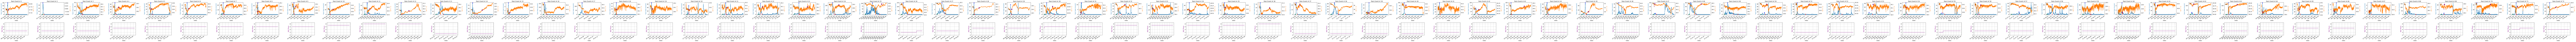

In [115]:
from RainEvent_Toolbox import sst_rain_response
sst_event_list = sst_rain_response(rain_event_list = rain_event_list,
                                   sst = kt_10s,
                                   pre_onset_averaging = pre_onset_averaging)

Based on careful inspection, we're going to exclude rain events where either we are missing SST measurements or they appear to be contaminated by a signal that is present in SST and not in the Sea Snake that does not correspond to any trends in other physical variables measured.

In [116]:
exclude = [i-1 for i in [2, 38, 48]]
exclude

[1, 37, 47]

In [117]:
resub = [event for num,event in enumerate(rain_event_list) if num not in exclude]
sstsub = [event for num,event in enumerate(sst_event_list) if num not in exclude]

rain_event_list = resub
sst_event_list = sstsub

In [118]:
len(rain_event_list)

69

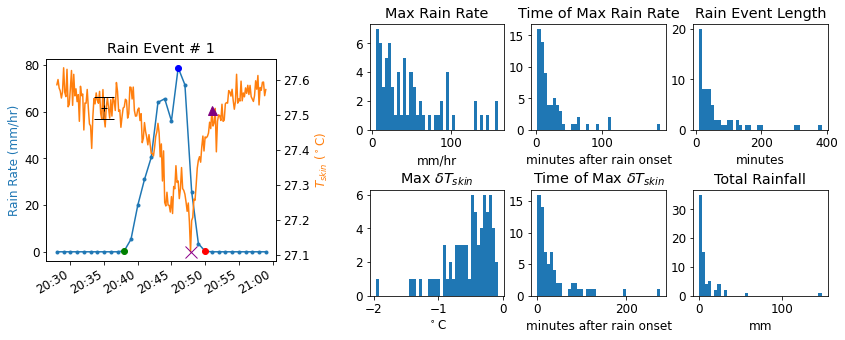

In [377]:
# plot summary of detected events
from RainEvent_Toolbox import extract_event_characteristics, plot_histograms
rain_events_summary = extract_event_characteristics(rain_event_list, sst_event_list)

#new plot that combines an example event with the histograms
fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot2grid(shape=(8,20),loc=(1,0),rowspan=6,colspan=6)

#----example event--
event_num = 0
start = pd.to_datetime(rain_event_list[event_num].attrs['Rain Onset'])
end = pd.to_datetime(rain_event_list[event_num].attrs['Rain End'])
first = rain_event_list[event_num].index[0]
last = rain_event_list[event_num].index[-1]
#plot precipitation rate
rain_event_list[event_num].P.plot.line('-o',ax=ax1,markersize=3,fillstyle=None)
ax1.set_ylabel('Rain Rate (mm/hr)',color='C0')
ax1.set_xlabel('')

#plot rainfall start and end times
ax1.plot(start,rain_event_list[event_num].P.sel(index=start),'.g',markersize=12,fillstyle=None)
ax1.plot(end,rain_event_list[event_num].P.sel(index=end),'.r',markersize=12,fillstyle=None)
#plot rainfall peak
ax1.plot(rain_event_list[event_num].attrs['Peak Time'],rain_event_list[event_num].attrs['Peak Rate'],'.b',markersize=12,fillstyle=None)

#plot SST
ax2 = ax1.twinx()
sst_event_list[event_num].sst.plot.line('C1',ax=ax2,fillstyle=None)
ax2.set_ylabel('$T_{skin}$ ($^\circ$C)',color='C1')
#plot max δSST and pre-onset mean + std
try:
    ax2.plot(sst_event_list[event_num].attrs['Time of max δsst'],sst_event_list[event_num].sst.sel(index=sst_event_list[event_num].attrs['Time of max δsst']),'x',color='darkmagenta',markersize=12)
    ax2.errorbar(sst_event_list[event_num].attrs['pre-onset time'],sst_event_list[event_num].attrs['pre-onset mean'],yerr=sst_event_list[event_num].attrs['pre-onset std'],fmt='+k',ecolor='k',capsize=10)
except KeyError:
    None

try:
    ax2.plot(sst_event_list[event_num].attrs['Time of sst recovery'],sst_event_list[event_num].sst.sel(index=sst_event_list[event_num].attrs['Time of sst recovery']),'^',color='purple',markersize=9)
except KeyError:
    None

#title
ax1.set_title(f'Rain Event # {event_num+1}')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#----histograms----
nbins=40
ax3 = plt.subplot2grid(shape=(10,5),loc=(0,2),rowspan=4,colspan=1)
ax4 = plt.subplot2grid(shape=(10,5),loc=(0,3),rowspan=4,colspan=1)
ax5 = plt.subplot2grid(shape=(10,5),loc=(0,4),rowspan=4,colspan=1)
ax6 = plt.subplot2grid(shape=(10,5),loc=(6,2),rowspan=4,colspan=1)
ax7 = plt.subplot2grid(shape=(10,5),loc=(6,3),rowspan=4,colspan=1)
ax8 = plt.subplot2grid(shape=(10,5),loc=(6,4),rowspan=4,colspan=1)

rain_events_summary.rain_max.plot.hist(ax=ax3,bins=nbins);
ax3.set_title('Max Rain Rate')
ax3.set_xlabel('mm/hr')

rain_events_summary.t_rain_max.plot.hist(ax=ax4,bins=nbins);
ax4.set_title('Time of Max Rain Rate')
ax4.set_xlabel('minutes after rain onset')

rain_events_summary.L_rain.plot.hist(ax=ax5,bins=nbins);
ax5.set_title('Rain Event Length')
ax5.set_xlabel('minutes')

rain_events_summary.δsst_max.plot.hist(ax=ax6,bins=nbins);
ax6.set_title('Max $δT_{skin}$')
ax6.set_xlabel('$^\circ$C')

rain_events_summary.t_δsst_max.plot.hist(ax=ax7,bins=nbins);
ax7.set_title('Time of Max $δT_{skin}$')
ax7.set_xlabel('minutes after rain onset')

rain_events_summary.rain_total.plot.hist(ax=ax8,bins=nbins)
ax8.set_title('Total Rainfall')
ax8.set_xlabel('mm');

#plt.tight_layout()
#plt.subplots_adjust(wspace=0.2)
plt.savefig('./Figures/Example Event + Histograms v4.png',dpi=300)


### 3. SST Modeling

In [90]:
%autoreload
from Ocean_Skin_Model import ocean_skin

In [91]:
%autoreload
from Ocean_Skin_Model import ocean_skin

TSG_depth = 5 #[m] depth of ship intake

# run modified (& regular) Bellenger model for each rain event and add the outputs to the rain_event_list
for event_num in np.arange(0,len(rain_event_list)):

    #------------SET UP MODEL INPUT-----------------
    event = rain_event_list[event_num]
    
    U = event.Ur10.values
    T_fnd = event.TseaTSG.values
    T_air = event.T10.values
    q = event.Q10.values/1000 # unit conversion g/kg -> kg/kg
    rsds = -event.Solardn.values
    p = event.Pair10.values
    rain = event.P.values
    shf = event.shf.values 
    lhf = event.lhf.values 
    rln = event.IRdn.values + event.IRup.values #net IR, positive upwards
    tau = event.stress.values
    s1 = event.SalTSG.values
    #initialize time as number of elapsed seconds from first timestep
    time = (event.index - event.index[0]).values.astype(float) * 10**-9

    #---------------RUN MODEL WITH VOLUME FRACTION ON-------------------
    model_vF = pd.DataFrame(index=event.index.values)
    [t_int_vF, s_int_vF, tkt_vF, tks_vF, dter_vF, dser_vF, dt_ns_vF, ds_ns_vF, rf_vF, taur_vF] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=True, spread_flag=True)
    
    #---------------RUN MODEL WITH VOLUME FRACTION OFF------------------
    model = pd.DataFrame(index=event.index.values)
    [t_int, s_int, tkt, tks, dter, dser, dt_ns, ds_ns, rf, taur] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=False, spread_flag=False)

    #---------------ASSIGN OUTPUT PARAMETERS TO RAIN EVENT--------------
    rain_event_list[event_num]['t_int_vF'] = ('index', t_int_vF)
    rain_event_list[event_num]['s_int_vF'] = ('index', s_int_vF)
    rain_event_list[event_num]['tkt_vF'] = ('index', tkt_vF)
    rain_event_list[event_num]['tks_vF'] = ('index', tks_vF)
    rain_event_list[event_num]['dter_vF'] = ('index', dter_vF)
    rain_event_list[event_num]['dser_vF'] = ('index', dser_vF)
    rain_event_list[event_num]['dt_ns_vF'] = ('index', dt_ns_vF)
    rain_event_list[event_num]['ds_ns_vF'] = ('index', ds_ns_vF)
    rain_event_list[event_num]['rf_vF'] = ('index', rf_vF)
    rain_event_list[event_num]['taur_vF'] = ('index', taur_vF)
    
    rain_event_list[event_num]['t_int'] = ('index', t_int)
    rain_event_list[event_num]['s_int'] = ('index', s_int)
    rain_event_list[event_num]['tkt'] = ('index', tkt)
    rain_event_list[event_num]['tks'] = ('index', tks)
    rain_event_list[event_num]['dter'] = ('index', dter)
    rain_event_list[event_num]['dser'] = ('index', dser)
    rain_event_list[event_num]['dt_ns'] = ('index', dt_ns)
    rain_event_list[event_num]['ds_ns'] = ('index', ds_ns)
    rain_event_list[event_num]['rf'] = ('index', rf)
    rain_event_list[event_num]['taur'] = ('index', taur)

100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 2539.25it/s]


## Step 3 again but feeding the Model with Sea Snake

In [92]:
%autoreload
from Ocean_Skin_Model import ocean_skin

In [93]:
%autoreload
from Ocean_Skin_Model import ocean_skin

TSG_depth = 0.05 #[m] depth of sea snake now -  try 10cm instead of 5 for consistency with previous studies?

# run modified (& regular) Bellenger model for each rain event and add the outputs to the rain_event_list
for event_num in np.arange(0,len(rain_event_list)):

    #------------SET UP MODEL INPUT-----------------
    event = rain_event_list[event_num]
    
    U = event.Ur10.values
    T_fnd = event.Tsea.values
    T_air = event.T10.values
    q = event.Q10.values/1000 # unit conversion g/kg -> kg/kg
    rsds = -event.Solardn.values
    p = event.Pair10.values
    rain = event.P.values
    shf = event.shf.values 
    lhf = event.lhf.values 
    rln = event.IRdn.values + event.IRup.values #net IR, positive upwards
    tau = event.stress.values
    s1 = event.SalTSG.values
    #initialize time as number of elapsed seconds from first timestep
    time = (event.index - event.index[0]).values.astype(float) * 10**-9

    #---------------RUN MODEL WITH VOLUME FRACTION ON-------------------
    model_vF = pd.DataFrame(index=event.index.values)
    [t_int_vF, s_int_vF, tkt_vF, tks_vF, dter_vF, dser_vF, dt_ns_vF, ds_ns_vF, rf_vF, taur_vF] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=True, spread_flag=True)
    
    #---------------RUN MODEL WITH VOLUME FRACTION OFF------------------
    model = pd.DataFrame(index=event.index.values)
    [t_int, s_int, tkt, tks, dter, dser, dt_ns, ds_ns, rf, taur] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=False, spread_flag=True)

    #---------------ASSIGN OUTPUT PARAMETERS TO RAIN EVENT--------------
    rain_event_list[event_num]['t_int_vF_SS'] = ('index', t_int_vF)
    rain_event_list[event_num]['s_int_vF_SS'] = ('index', s_int_vF)
    rain_event_list[event_num]['tkt_vF_SS'] = ('index', tkt_vF)
    rain_event_list[event_num]['tks_vF_SS'] = ('index', tks_vF)
    rain_event_list[event_num]['dter_vF_SS'] = ('index', dter_vF)
    rain_event_list[event_num]['dser_vF_SS'] = ('index', dser_vF)
    rain_event_list[event_num]['dt_ns_vF_SS'] = ('index', dt_ns_vF)
    rain_event_list[event_num]['ds_ns_vF_SS'] = ('index', ds_ns_vF)
    rain_event_list[event_num]['rf_vF_SS'] = ('index', rf_vF)
    rain_event_list[event_num]['taur_vF_SS'] = ('index', taur_vF)
    
    rain_event_list[event_num]['t_int_SS'] = ('index', t_int)
    rain_event_list[event_num]['s_int_SS'] = ('index', s_int)
    rain_event_list[event_num]['tkt_SS'] = ('index', tkt)
    rain_event_list[event_num]['tks_SS'] = ('index', tks)
    rain_event_list[event_num]['dter_SS'] = ('index', dter)
    rain_event_list[event_num]['dser_SS'] = ('index', dser)
    rain_event_list[event_num]['dt_ns_SS'] = ('index', dt_ns)
    rain_event_list[event_num]['ds_ns_SS'] = ('index', ds_ns)
    rain_event_list[event_num]['rf_SS'] = ('index', rf)
    rain_event_list[event_num]['taur_SS'] = ('index', taur)

100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 2357.23it/s]


### 4. Composite Rain Event

First we want to calculate the deltas for any variables we might be interested in from the rain events ($\delta$SST was already calculated):

In [94]:
#because the extract_composite_event function is looking for a variable of the form δ{"name"}, we're fudging HsC by naming it with a delta in front when we first add it to the dataset. Kind of clunky but it works.
param_list = ['Tsea','TseaTSG','SalTSG','T02','T10','U10','Precip','rhf','SST','HsC','lhf','shf','Q02','wspd','t_int','t_int_vF','s_int','s_int_vF','t_int_SS','t_int_vF_SS','s_int_SS','s_int_vF_SS','SHF_fromBulk','SHF_fromSkin','Δq_skin_air','ΔT_skin_air']

In [95]:
from RainEvent_Toolbox import calculate_deltas
rain_event_list = calculate_deltas(rain_event_list = rain_event_list,
                                   param_list = param_list,
                                   pre_onset_averaging = pre_onset_averaging)

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Now we're ready to put together a composite plot of these delta variables for all rain events. The key is to normalize the timescale by the time to peak SST response, i.e. 
$$ Normalized Time = \frac{(CurrentMinute - StartMinute)}{(Minutes to Max \delta SST)} $$

This way, the rain start is at zero and the peak SST response is at 1. This allows us to superimpose all the rain events in a meaningful way. I've also scaled the size of the dots to indicate what proportion of events were involved in each bin (all events are included between timesteps 0 and 1, of course).

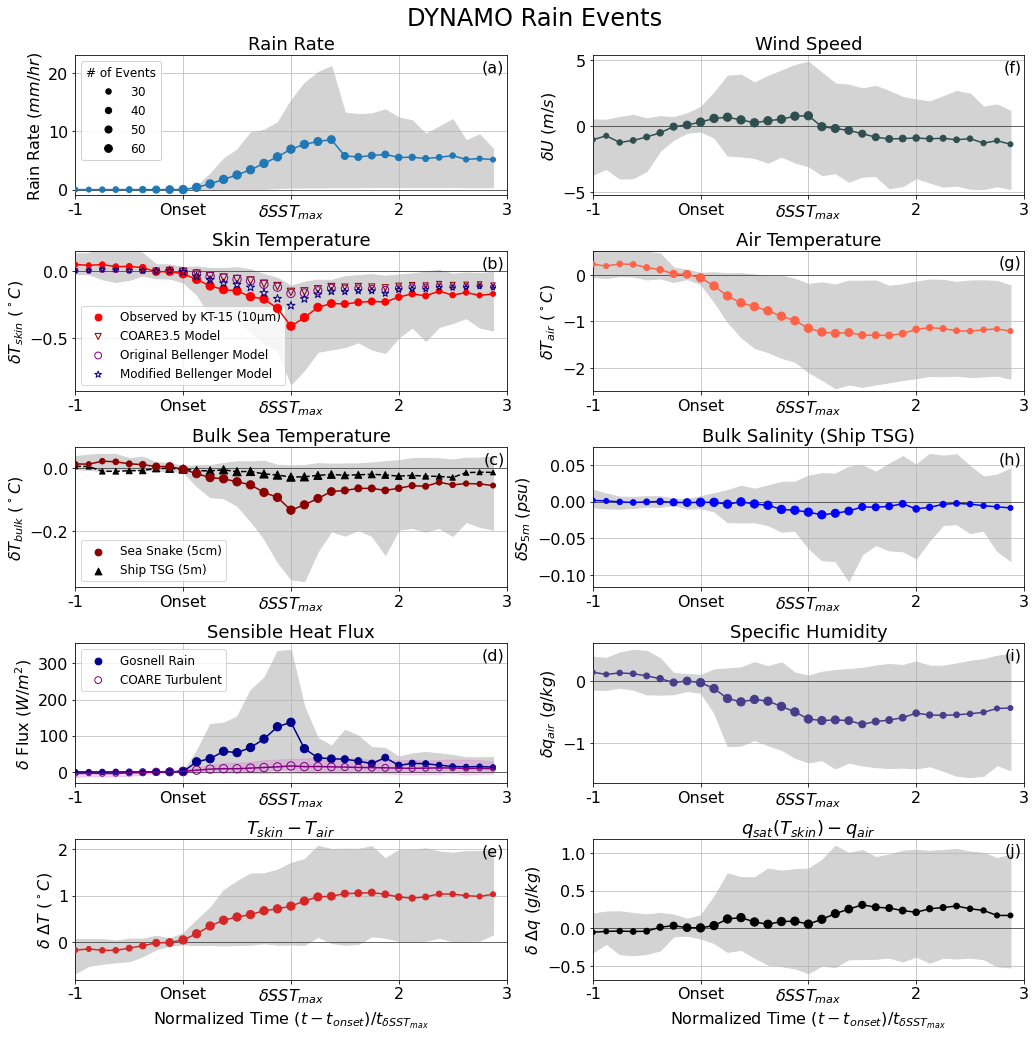

In [96]:
plt.rcParams['font.size'] = 12
%autoreload
from RainEvent_Toolbox import extract_composite_event_10panel
composite_event = extract_composite_event_10panel(rain_event_list = rain_event_list, 
                                          sst_event_list = sst_event_list, 
                                          param_list = param_list, 
                                          start = -1, 
                                          stop = 3, 
                                          spacing = 1/8,
                                          plotflag = 1,
                                          title = 'DYNAMO Rain Events')
#plt.savefig('./Figures/Composite Events REVISED v5.png', dpi=300)

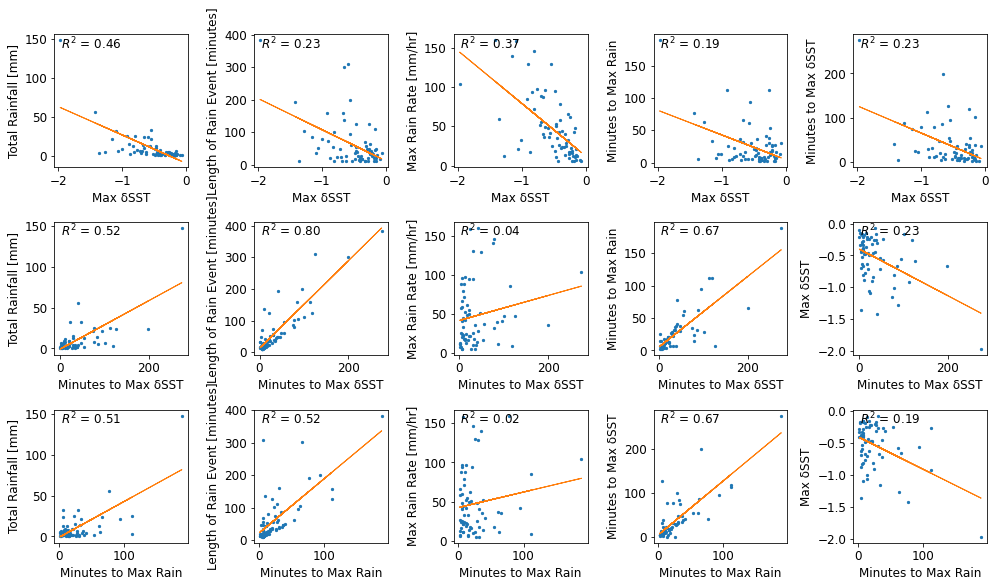

In [251]:
%autoreload
from RainEvent_Toolbox import plot_relationships
plot_relationships(rain_events_summary)
#plt.savefig('./Figures/Scatterplots v3.png')

The highest correlations are between:
- Minutes to Max $\delta$SST vs. Length of Rain Event ($R^2$ = 0.80)
- Minutes to Max $\delta$SST vs. Minutes to Max Rain ($R^2$ = 0.67)

Text(0.75, 0.79, '$R^2$ = 0.95')

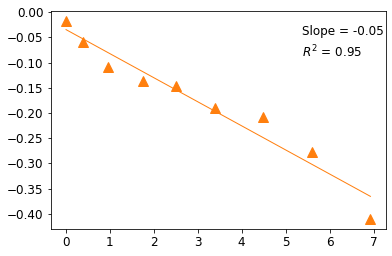

In [260]:
#Linear fit to composite values of rain rate vs deltaSST
compStart, compEnd = 0,1

#plot means across events
δsst_mean = composite_event.sel(index=slice(compStart, compEnd)).δsst.mean(dim='event',skipna=True)
δsst_std = composite_event.sel(index=slice(compStart, compEnd)).δsst.std(dim='event',skipna=True)
precip_mean = composite_event.sel(index=slice(compStart, compEnd)).δPrecip.mean(dim='event',skipna=True)
precip_std = composite_event.sel(index=slice(compStart, compEnd)).δPrecip.std(dim='event',skipna=True)
plt.plot(precip_mean, δsst_mean,'^', color='C1',markersize=10, zorder=10)

#fit means
x,y = precip_mean, δsst_mean
coef = np.polyfit(x,y,1)
slope, intercept = coef[0], coef[1]
r_value = np.corrcoef(x, y)[0, 1]
    
poly1d_fn = np.poly1d(coef) # poly1d_fn is now a function which takes in x and returns an estimate for y
plt.plot(x, poly1d_fn(x), 'C1', linewidth=1, zorder=2)
plt.annotate('Slope = %0.2f' % slope, xy=(0.75, 0.89), xycoords='axes fraction')
plt.annotate('$R^2$ = %0.2f' % r_value**2, xy=(0.75, 0.79), xycoords='axes fraction')

In [263]:
peak_means = composite_event.mean(dim='event',skipna=True).sel(index=1)
peak_means

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    index          float64 1.0
Data variables:
    δsst           float64 -0.4103
    δTsea          float64 -0.1342
    δTseaTSG       float64 -0.02933
    δSalTSG        float64 -0.01432
    δT02           float64 -1.147
    δT10           float64 -1.226
    δU10           float64 0.7363
    δPrecip        float64 6.928
    δrhf           float64 137.0
    δSST           float64 -0.1535
    δHsC           float64 0.9153
    δlhf           float64 30.19
    δshf           float64 16.25
    δQ02           float64 -0.6108
    δwspd          float64 0.7867
    δt_int         float64 -0.2068
    δt_int_vF      float64 -0.09268
    δs_int         float64 -1.881
    δs_int_vF      float64 -1.879
    δt_int_SS      float64 -0.2797
    δt_int_vF_SS   float64 -0.165
    δs_int_SS      float64 -1.792
    δs_int_vF_SS   float64 -1.791
    δSHF_fromBulk  float64 17.19
    δSHF_fromSkin  float64 13.33
    δΔq_skin_air   float64 0.05396
    δΔT_sk

In [265]:
composite_event.mean(dim='event',skipna=True).δSalTSG.min()

<xarray.DataArray 'δSalTSG' ()>
array(-0.017869)

## 5. Plotting Skin Temp Observations vs Models

In [273]:
def diff_plot(observed, modeled, color, axis, cmap, marker, size):
    observed  = np.asarray(observed)
    modeled   = np.asarray(modeled)
    diff      = modeled - observed                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.nanstd(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 2*sd
    CI_high   = md + 2*sd

    axis.scatter(observed, diff, c=color, s=size, cmap=cmap, marker=marker)
    axis.axhline(md,           color='black', linestyle='-')
    axis.axhline(md + 2*sd, color='gray', linestyle='--')
    axis.axhline(md - 2*sd, color='gray', linestyle='--')
    xtext = np.nanmax(observed)#*1.001
    axis.text(x=xtext+0.15,y=md-0.04,s='Mean')
    axis.text(x=xtext+0.15,y=md-0.04 + 2*sd, s='+2σ', color='gray')
    axis.text(x=xtext+0.15,y=md-0.04 - 2*sd, s='-2σ', color='gray')
    axis.text(x=xtext+0.1,y=1.3, s=f'{md.round(3)} $\pm$ {sd.round(3)}', ha='right')


In [274]:
num_list = []
time_list = []
sst_list = []
t_int_list = []
t_int_vF_list = []
t_int_SS_list = []
t_int_vF_SS_list = []
sst_raincoare_list = []
sst_raincoare_SS_list = []
sst_coare_list = []
sst_coare_SS_list = []
sw_list =[]
p_list = []


for event_num in np.arange(len(rain_event_list)):
    if event_num not in exclude:
        event = rain_event_list[event_num]
        #resample to 1min and fill in any missing gaps
        sst = sst_event_list[event_num].sst.resample(index='1min').mean().interp_like(event)
        sst = sst.where(np.isfinite(sst),drop=True).where(event.P > 0.5, drop=True)
        event = event.where(np.isfinite(sst),drop=True).where(event.P >0.5, drop=True)

        num_list.append(event_num*np.ones_like(sst.values))
        time_list.append(event.index.values)
        sst_list.append(sst.values)
        t_int_list.append(event.t_int.values)
        t_int_vF_list.append(event.t_int_vF.values)
        t_int_SS_list.append(event.t_int_SS.values)
        t_int_vF_SS_list.append(event.t_int_vF_SS.values)

        p_list.append(event.P.values)
        sw_list.append(event.Solardn.values)

        sst_raincoare_list.append(event.SSTrain_fromBulk.values)
        sst_raincoare_SS_list.append(event.SSTrain.values)
        sst_coare_list.append(event.SST_fromBulk.values)
        sst_coare_SS_list.append(event.SST.values)
    
event_nums = np.concatenate(num_list)
time = np.concatenate(time_list)
sst = np.concatenate(sst_list)
t_int = np.concatenate(t_int_list)
t_int_vF = np.concatenate(t_int_vF_list)
t_int_SS = np.concatenate(t_int_SS_list)
t_int_vF_SS = np.concatenate(t_int_vF_SS_list)
sst_raincoare = np.concatenate(sst_raincoare_list)
sst_raincoare_SS = np.concatenate(sst_raincoare_SS_list)
sst_coare = np.concatenate(sst_coare_list)
sst_coare_SS = np.concatenate(sst_coare_SS_list)
sw = np.concatenate(sw_list)
p = np.concatenate(p_list)

Text(0.06, 0.23, 'Temperature\nInput: 5m\nShip TSG')

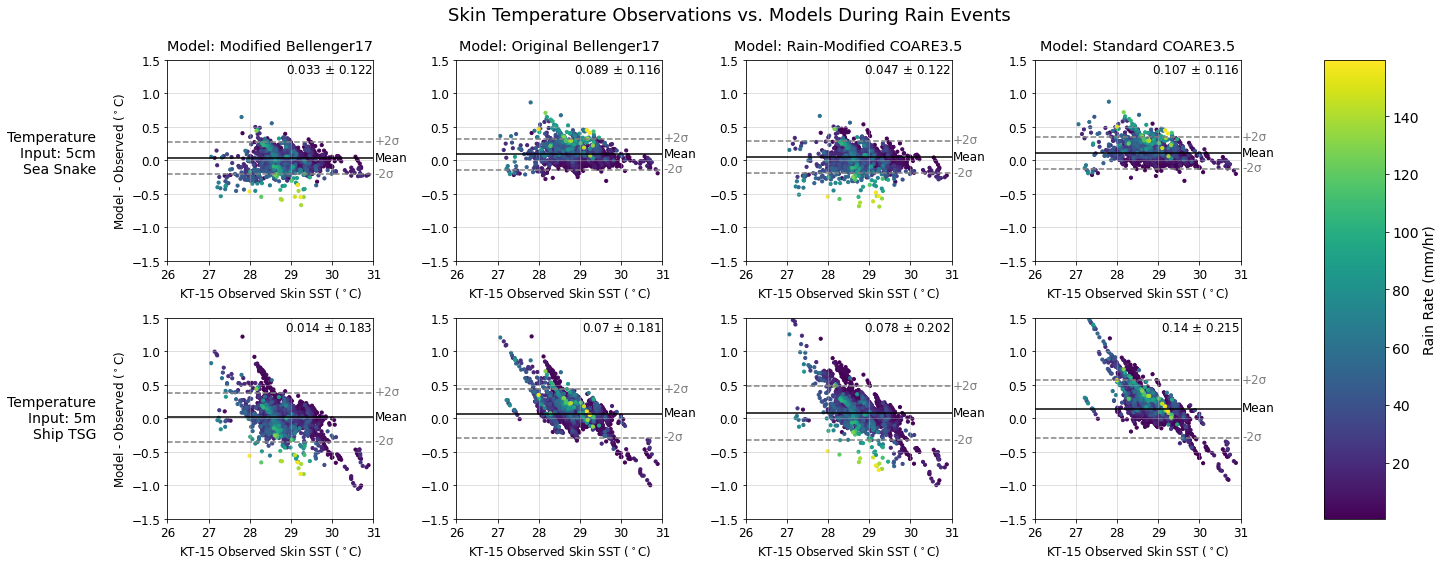

In [150]:
#make version of this figure that is 2 rows (SS or TSG) and 4 columns (ModBel, OrigBel, ModCOARE, OrigCOARE) plus a colorbar on the right and text labels on the left
fig = plt.figure(figsize=(20,8))

axx00 = plt.subplot2grid(shape=(2,10),loc=(0,1),rowspan=1,colspan=2)
axx01 = plt.subplot2grid(shape=(2,10),loc=(0,3),rowspan=1,colspan=2)
axx02 = plt.subplot2grid(shape=(2,10),loc=(0,5),rowspan=1,colspan=2)
axx03 = plt.subplot2grid(shape=(2,10),loc=(0,7),rowspan=1,colspan=2)
axx10 = plt.subplot2grid(shape=(2,10),loc=(1,1),rowspan=1,colspan=2)
axx11 = plt.subplot2grid(shape=(2,10),loc=(1,3),rowspan=1,colspan=2)
axx12 = plt.subplot2grid(shape=(2,10),loc=(1,5),rowspan=1,colspan=2)
axx13 = plt.subplot2grid(shape=(2,10),loc=(1,7),rowspan=1,colspan=2)
axxcb = plt.subplot2grid(shape=(2,10),loc=(0,9),rowspan=2,colspan=1)

cmap = mpl.cm.viridis
marker = 'o'
size = 10

#sort the plotting order by precip amount so that we see all the high-precip values on top in the scatterplots
order = np.argsort(p)

diff_plot(sst[order], t_int_SS[order], p[order], axis=axx00, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], t_int_vF_SS[order], p[order], axis=axx01, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], sst_raincoare_SS[order], p[order], axis=axx02, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], sst_coare_SS[order], p[order], axis=axx03, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], t_int[order], p[order], axis=axx10, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], t_int_vF[order], p[order], axis=axx11, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], sst_raincoare[order], p[order], axis=axx12, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], sst_coare[order], p[order], axis=axx13, cmap=cmap, marker=marker, size=size)

norm = mpl.colors.Normalize(vmin = p.min(), vmax=p.max())
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=axxcb)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='Rain Rate (mm/hr)', fontsize=14)

pad=10
axx00.set_title('Model: Modified Bellenger17', pad=pad)
axx01.set_title('Model: Original Bellenger17', pad=pad)
axx02.set_title('Model: Rain-Modified COARE3.5', pad=pad)
axx03.set_title('Model: Standard COARE3.5', pad=pad)

plt.suptitle('Skin Temperature Observations vs. Models During Rain Events',fontsize=18)#,y=0.95)
    
axx00.set_ylabel('Model - Observed ($^\circ$C)')
axx10.set_ylabel('Model - Observed ($^\circ$C)')

for axis in [axx00,axx01,axx02,axx03,axx10,axx11,axx12,axx13]:
    axis.set_xlabel('KT-15 Observed Skin SST ($^\circ$C)')
    axis.grid(alpha=0.5)
    axis.set_ylim([-1.5,1.5])
    axis.set_xlim([26,31])

        
plt.tight_layout()
plt.text(x=0.06,y=0.69,s='Temperature\nInput: 5cm\nSea Snake', transform=fig.transFigure,fontdict={'size':14},ha='right')
plt.text(x=0.06,y=0.23,s='Temperature\nInput: 5m\nShip TSG', transform=fig.transFigure,fontdict={'size':14},ha='right')


#plt.savefig('./Figures/Observed vs. Modeled SST rain data v5.png',bbox_inches='tight')

#### TAKE HOME MESSAGE:
I think we can basically conclude that the major excursions we see away from effective prediction are a consequence of advective features passing through. This is borne out in the individual plots, which show that sometimes there are SST signals which don't correspond in any meaningful way to the local variables. The overarching message here is that by modeling the rain physics we can improve the skew in our SST prediction even though we aren't able to tighten the variability bounds very much. The sensible heat flux due to rain is the dominant term, and just by adding it to COARE we can do a little bit better than Bellenger; by making the modification to Bellenger we can do even better. However the models that incorporate the full Gosnell heat flux do tend to overestimate the amount of cooling expected at very high rain rates.

In [286]:
def get_r2_linear(x, y):
    '''Only works for linear fits'''
    return np.corrcoef(x, y)[0, 1]**2

def diff_plot_2(observed, modeled, xvalues, color, axis, cmap, marker, size):
    observed  = np.asarray(observed)
    modeled   = np.asarray(modeled)
    diff      = modeled - observed                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.nanstd(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 2*sd
    CI_high   = md + 2*sd

    axis.scatter(xvalues, diff, c=color, s=size, cmap=cmap, marker=marker,zorder=1)
    axis.axhline(md,           color='dimgrey', linestyle='-',zorder=0)
    axis.axhline(md + 2*sd, color='darkgray', linestyle='--',zorder=0)
    axis.axhline(md - 2*sd, color='darkgray', linestyle='--',zorder=0)
    
    #xthresh=np.max(xvalues) #only fit to values below this threshold
    #inds = [i for i in range(len(xvalues)) if xvalues[i] < xthresh] #indices where the xvalue is below threshold
    diffsub = diff#[inds]  #[y if x<thresh for x, y, thresh in zip(xvalues, diff, xthresh)]
    xsub = xvalues#[inds] 
    
    coef = np.polyfit(xsub,diffsub,1)
    poly1d_fn = np.poly1d(coef) # poly1d_fn is now a function which takes in x and returns an estimate for y
    axis.plot(xvalues, poly1d_fn(xvalues), ':k') #'--k'=black dashed line, 'yo' = yellow circle marker
    
    r2 = get_r2_linear(xsub,diffsub)
    
    xtext = np.nanmax(xvalues)#*1.001
    axis.text(x=xtext+2,y=md-0.04,s='Mean',color='dimgrey')
    axis.text(x=xtext+2,y=md-0.04 + 2*sd, s='+2σ', color='darkgray')
    axis.text(x=xtext+2,y=md-0.04 - 2*sd, s='-2σ', color='darkgray')
    axis.text(x=xtext-1,y=1.3, s=f'Mean = {md.round(3)} $\pm$ {2*sd.round(3)}', ha='right')
    axis.text(x=xtext-1,y=1, s=f'y = {coef[0].round(4)}x + {coef[1].round(3)}', ha='right')
    axis.text(x=xtext-1,y=0.7, s=f'$R^2$ = {r2.round(3)}', ha='right')


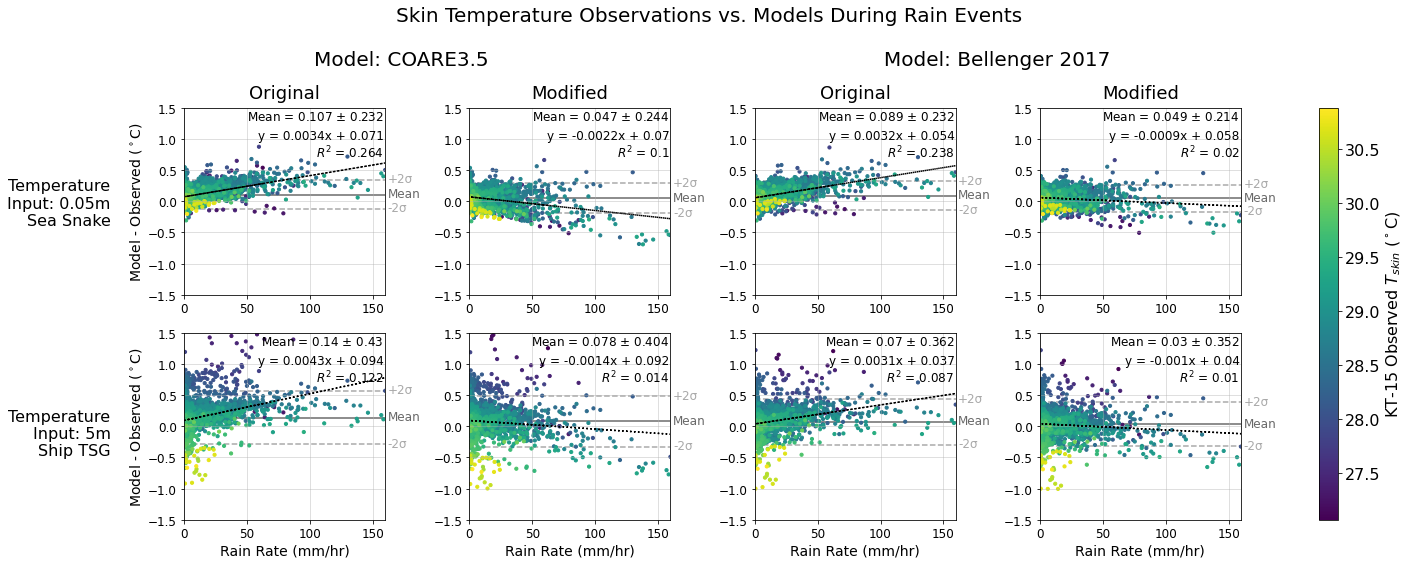

In [287]:
#make version of this figure that is 2 rows (SS or TSG) and 4 columns (ModBel, OrigBel, ModCOARE, OrigCOARE) with RAIN RATE ON X-AXIS
ftsz = 14

fig = plt.figure(figsize=(19,8))

axx00 = plt.subplot2grid(shape=(2,10),loc=(0,1),rowspan=1,colspan=2)
axx01 = plt.subplot2grid(shape=(2,10),loc=(0,3),rowspan=1,colspan=2)
axx02 = plt.subplot2grid(shape=(2,10),loc=(0,5),rowspan=1,colspan=2)
axx03 = plt.subplot2grid(shape=(2,10),loc=(0,7),rowspan=1,colspan=2)
axx10 = plt.subplot2grid(shape=(2,10),loc=(1,1),rowspan=1,colspan=2)
axx11 = plt.subplot2grid(shape=(2,10),loc=(1,3),rowspan=1,colspan=2)
axx12 = plt.subplot2grid(shape=(2,10),loc=(1,5),rowspan=1,colspan=2)
axx13 = plt.subplot2grid(shape=(2,10),loc=(1,7),rowspan=1,colspan=2)

cmap = mpl.cm.viridis
marker = 'o'
size = 10

#sort the plotting order by precip amount so that we see all the high-precip values on top in the scatterplots
order = np.argsort(sst)

diff_plot_2(sst[order], t_int_SS[order], p[order], sst[order], axis=axx03, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], t_int_vF_SS[order], p[order], sst[order], axis=axx02, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], sst_raincoare_SS[order], p[order], sst[order], axis=axx01, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], sst_coare_SS[order], p[order], sst[order], axis=axx00, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], t_int[order], p[order], sst[order], axis=axx13, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], t_int_vF[order], p[order], sst[order], axis=axx12, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], sst_raincoare[order], p[order], sst[order], axis=axx11, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], sst_coare[order], p[order], sst[order], axis=axx10, cmap=cmap, marker=marker, size=size)


pad=10
axx03.set_title('Modified', pad=pad,fontdict={'size':ftsz+4})
axx02.set_title('Original', pad=pad,fontdict={'size':ftsz+4})
axx01.set_title('Modified', pad=pad,fontdict={'size':ftsz+4})
axx00.set_title('Original', pad=pad,fontdict={'size':ftsz+4})

plt.suptitle('Skin Temperature Observations vs. Models During Rain Events \n \nModel: COARE3.5                                                              Model: Bellenger 2017',fontsize=20)#,y=0.95)
    
axx00.set_ylabel('Model - Observed ($^\circ$C)',fontdict={'size':ftsz})
axx10.set_ylabel('Model - Observed ($^\circ$C)',fontdict={'size':ftsz})

for axis in [axx10,axx11,axx12,axx13]:
    axis.set_xlabel('Rain Rate (mm/hr)',fontdict={'size':ftsz})

for axis in [axx00,axx01,axx02,axx03,axx10,axx11,axx12,axx13]:
    axis.grid(alpha=0.5)
    axis.set_ylim([-1.5,1.5])
    axis.set_xlim([0,p.max()])

        
plt.tight_layout()

axxcb = plt.subplot2grid(shape=(2,30),loc=(0,28),rowspan=2,colspan=1)

norm = mpl.colors.Normalize(vmin = sst.min(), vmax=sst.max())
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=axxcb)
cbar.ax.tick_params(labelsize=ftsz+2)
cbar.set_label(label='KT-15 Observed $T_{skin}$ ($^\circ$C)', fontsize=ftsz+2)


plt.text(x=0.06,y=0.6,s='Temperature\nInput: 0.05m\nSea Snake', transform=fig.transFigure,fontdict={'size':ftsz+2},ha='right')
plt.text(x=0.06,y=0.2,s='Temperature\nInput: 5m\nShip TSG', transform=fig.transFigure,fontdict={'size':ftsz+2},ha='right')


plt.savefig('./Figures/Observed vs. Modeled SST rain data v10.png',bbox_inches='tight', dpi=300)

### Consider an additional plot of fit slope vs. cutoff threshold! Slopes get progressively closer to zero as you reduce the threshold from 50->30->etc.
This is no longer as compelling now that I removed the volume scaling from the buoyancy flux calculations as well - ModBel is working pretty darn good

In [278]:
def rainThresh_slope(observed, modeled, xvalues, xthresh):
    observed  = np.asarray(observed)
    modeled   = np.asarray(modeled)
    diff      = modeled - observed
    
    inds = [i for i in range(len(xvalues)) if xvalues[i] < xthresh] #indices where the xvalue is below threshold
    diffsub = diff[inds]
    xsub = xvalues[inds] 
    
    coef = np.polyfit(xsub,diffsub,1)
    slope = coef[0]
    
    r2 = get_r2_linear(xsub,diffsub)
    
    return slope, r2

thresholds = np.arange(10,160)

slopes_b17_SS, r2s_b17_SS = [], []
slopes_b17mod_SS, r2s_b17mod_SS = [], []
slopes_b17, r2s_b17 = [], []
slopes_b17mod, r2s_b17mod = [], []
slopes_coare_SS, r2s_coare_SS = [], []
slopes_coaremod_SS, r2s_coaremod_SS = [], []
slopes_coare, r2s_coare = [], []
slopes_coaremod, r2s_coaremod = [], []

for xthresh in thresholds:
    #----SEA SNAKE----
    #B17 modified
    slope, r2 = rainThresh_slope(sst, t_int_SS, p, xthresh)
    slopes_b17mod_SS.append(slope), r2s_b17mod_SS.append(r2)
    #B17 original
    slope, r2 = rainThresh_slope(sst, t_int_vF_SS, p, xthresh)
    slopes_b17_SS.append(slope), r2s_b17_SS.append(r2)
    #COARE modified
    slope, r2 = rainThresh_slope(sst, sst_raincoare_SS, p, xthresh)
    slopes_coaremod_SS.append(slope), r2s_coaremod_SS.append(r2)
    #COARE original
    slope, r2 = rainThresh_slope(sst, sst_coare_SS, p, xthresh)
    slopes_coare_SS.append(slope), r2s_coare_SS.append(r2)
    #----TSG----
    #B17 modified
    slope, r2 = rainThresh_slope(sst, t_int, p, xthresh)
    slopes_b17mod.append(slope), r2s_b17mod.append(r2)
    #B17 original
    slope, r2 = rainThresh_slope(sst, t_int_vF, p, xthresh)
    slopes_b17.append(slope), r2s_b17.append(r2)
    #COARE modified
    slope, r2 = rainThresh_slope(sst, sst_raincoare, p, xthresh)
    slopes_coaremod.append(slope), r2s_coaremod.append(r2)
    #COARE original
    slope, r2 = rainThresh_slope(sst, sst_coare, p, xthresh)
    slopes_coare.append(slope), r2s_coare.append(r2)

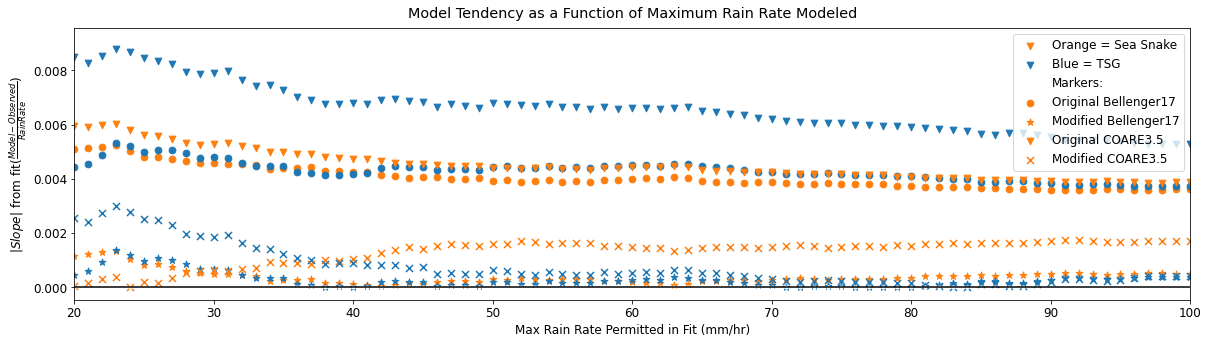

In [281]:
#OGB -> open circles
#MODB -> stars
#OGC -> down triangles
#MODC -> X
#C0 -> TSG input
#C1 -> SS input

fig,axx = plt.subplots(figsize=(20,5))

Css = 'C1'
Ctsg = 'C0'
sSS = 50
sTSG = 45

h1 = axx.scatter(thresholds,np.abs(slopes_b17mod_SS),marker='*',c=Css,s=sSS)
axx.scatter(thresholds,np.abs(slopes_b17mod),marker='*',c=Ctsg,s=sSS)

h2 = axx.scatter(thresholds,np.abs(slopes_b17_SS),marker='o',c=Css,facecolor='none',s=sTSG)
axx.scatter(thresholds,np.abs(slopes_b17),marker='o',c=Ctsg,facecolor='none',s=sTSG)

h3 = axx.scatter(thresholds,np.abs(slopes_coaremod_SS),marker='x',c=Css,s=sSS)
axx.scatter(thresholds,np.abs(slopes_coaremod),marker='x',c=Ctsg,s=sSS)

h4 = axx.scatter(thresholds,np.abs(slopes_coare_SS),marker='v',c=Css,s=sTSG)
h5 = axx.scatter(thresholds,np.abs(slopes_coare),marker='v',c=Ctsg,s=sTSG)

h6 = axx.scatter(thresholds,np.zeros_like(thresholds),c='white',s=10)
axx.plot(thresholds,np.zeros_like(thresholds),c='k')

axx.set_xlim([20,100])

plt.legend([h4,h5,h6,h2,h1,h4,h3],['Orange = Sea Snake', 'Blue = TSG', 'Markers:','Original Bellenger17', 'Modified Bellenger17', 'Original COARE3.5', 'Modified COARE3.5'],loc='upper right')

axx.set_ylabel('$|Slope|$ from fit($ \\frac{Model-Observed}{Rain Rate}$)')

axx.set_xlabel('Max Rain Rate Permitted in Fit (mm/hr)')

axx.set_title('Model Tendency as a Function of Maximum Rain Rate Modeled',pad=10)

plt.savefig('./Figures/Model Tendency vs Max Rain Rate Modeled v1.png')

## 5.5 Plotting $fV(z)$ for different rain rates

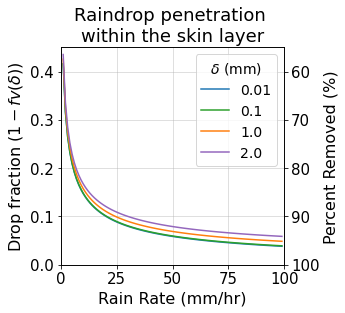

In [11]:
from Ocean_Skin_Model import fV

rains = np.arange(1,100)
Ps = rains / 3600. # convert mm/h -> kg m-2 s-1
zs = [0.00001, 0.0001, 0.001, 0.002]
cs = ['C0','C2','C1','C4']
handles = []

fig,axx = plt.subplots(figsize=(4,4))
for z,c in zip(zs,cs):
    fVs = []
    for rain in Ps:
        fVs.append(1-fV(z,rain))
    h = axx.plot(rains,fVs,color=c)
    handles.append(h)
    
lz = [z*1000 for z in zs]
axx.legend(labels=lz,title='$\delta$ (mm)',fontsize=14,title_fontsize=14)
axx.grid(alpha=0.5)
axx.set_xlim([0,100])
axx.set_ylim([0,0.45])
axx.set_xlabel('Rain Rate (mm/hr)',fontsize=16)
axx.tick_params(labelsize=15)
axx.set_ylabel('Drop fraction ($1-fv(\delta)$)',fontsize=16)
axx.set_title('Raindrop penetration \nwithin the skin layer',fontsize=18)

par = axx.twinx()
par.set_ylim([0,0.45])
par.set_yticks([0.0,0.1,0.2,0.3,0.4])
par.set_yticklabels(['100','90','80','70','60'])
par.tick_params(labelsize=15)
par.set_ylabel('Percent Removed (%)',fontsize=16)

plt.savefig('./Figures/fV plot v2.png',dpi=300,bbox_inches='tight')

In [343]:
num = 6
rains[num], fVs[num]

(7, 0.19698874339805494)

## 6. Plotting difference between skin and bulk temperature and resulting SHF from COARE

In [17]:
#calculate differential variables between skin and bulk
rv['skin_bulk_shf'] = rv.SHF_fromSkin - rv.SHF_fromBulk
rv['sst_skin'] = kt_10s.rolling(index=6).mean().interp_like(rv,method='linear') #take 1 minute rolling mean and then cast onto rv timestamps
rv['skin_bulk_sst'] = rv.sst_skin - rv.TseaTSG 

#subset rv to make the groupby_bins operation execute quickly
rv_sub = xr.merge([rv.P, rv.skin_bulk_shf, rv.skin_bulk_sst])
step=3
rv_gb = rv_sub.groupby_bins('P',bins=np.arange(0,160,step))
rv_Pmeans = rv_gb.mean()
#rv_Pq10 = rv_gb.reduce(np.nanquantile, q=0.1)
#rv_Pq90 = rv_gb.reduce(np.nanquantile, q=0.9)
rv_std = rv_gb.std()
#rv_Pcount = rv_gb.count()

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


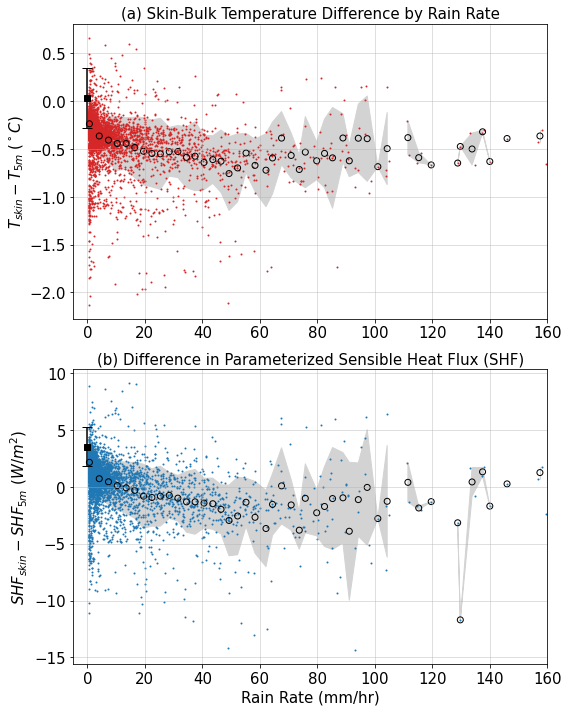

In [18]:
rv_rain = rv.where(rv.P>=0.5)
rv_dry = rv.where(rv.P<0.5)
fontsz = 15

fig,axx = plt.subplots(nrows=2,figsize=(8,10))

axx[0].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_bulk_sst+rv_std.skin_bulk_sst), y2=(rv_Pmeans.skin_bulk_sst-rv_std.skin_bulk_sst), color='lightgrey')
axx[0].scatter(rv_rain.P, rv_rain.skin_bulk_sst,s=1,c='C3')
axx[0].scatter(rv_Pmeans.P, rv_Pmeans.skin_bulk_sst, edgecolor='k', facecolor='None')
axx[0].errorbar(0,rv_dry.skin_bulk_sst.mean(), rv_dry.skin_bulk_sst.std(),capsize=5, marker='s',color='k')
axx[0].grid(alpha=0.5)

axx[1].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_bulk_shf+rv_std.skin_bulk_shf), y2=(rv_Pmeans.skin_bulk_shf-rv_std.skin_bulk_shf), color='lightgrey')
axx[1].scatter(rv_rain.P, rv_rain.skin_bulk_shf,s=1)
axx[1].scatter(rv_Pmeans.P, rv_Pmeans.skin_bulk_shf, edgecolor='k', facecolor='None')
axx[1].grid(alpha=0.5)
axx[1].errorbar(0,rv_dry.skin_bulk_shf.mean(), rv_dry.skin_bulk_shf.std(),capsize=5, marker='s',color='k')


axx[1].set_xlabel('Rain Rate (mm/hr)', fontsize=fontsz)
axx[1].set_ylabel('$SHF_{skin} - SHF_{5m}$ ($W/m^2$)', fontsize=fontsz)
axx[0].set_ylabel('$T_{skin} - T_{5m}$ ($^\circ C$)', fontsize=fontsz)

axx[0].set_title('(a) Skin-Bulk Temperature Difference by Rain Rate', fontsize=fontsz)
axx[1].set_title('(b) Difference in Parameterized Sensible Heat Flux (SHF)', fontsize=fontsz)

for axis in axx:
    axis.tick_params(axis='both', which='both', labelsize=fontsz)
    axis.set_xlim([-5,160])

plt.tight_layout()

#plt.savefig('./Figures/SST and SHF differences as function of Rain Rate v4.png')

#### Same but split into day and night

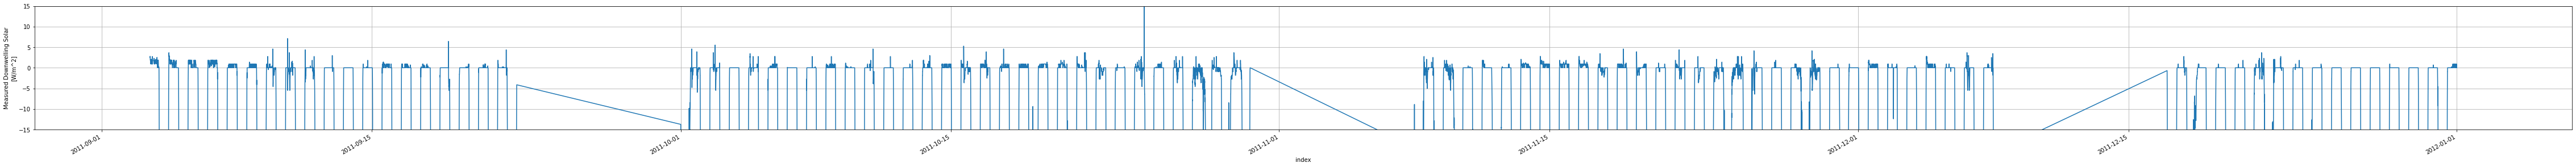

In [31]:
rv.Solardn.plot(figsize=(80,4))
plt.ylim([-15,15])
plt.grid()

In [32]:
#calculate differential variables between skin and bulk
rv['skin_bulk_shf'] = rv.SHF_fromSkin - rv.SHF_fromBulk
rv['sst_skin'] = kt_10s.rolling(index=6).mean().interp_like(rv,method='linear') #take 1 minute rolling mean and then cast onto rv timestamps
rv['skin_bulk_sst'] = rv.sst_skin - rv.TseaTSG 

#subset rv to make the groupby_bins operation execute quickly
rv_sub = xr.merge([rv.P, rv.skin_bulk_shf, rv.skin_bulk_sst, rv.Solardn])
#split into day and night 
rv_night = rv_sub.where(rv_sub.Solardn > -15) #when theres less than 15W/m^2 of solar energy, it night. Sign convention is negative for downwelling.
rv_day = rv_sub.where(rv_sub.Solardn <= -15)

step=3
rv_gb_night = rv_night.groupby_bins('P',bins=np.arange(0,160,step))
rv_gb_day = rv_day.groupby_bins('P',bins=np.arange(0,160,step))

rv_Pmeans_night = rv_gb_night.mean()
rv_Pmeans_day = rv_gb_day.mean()

rv_std_night = rv_gb_night.std()
rv_std_day = rv_gb_day.std()

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass d

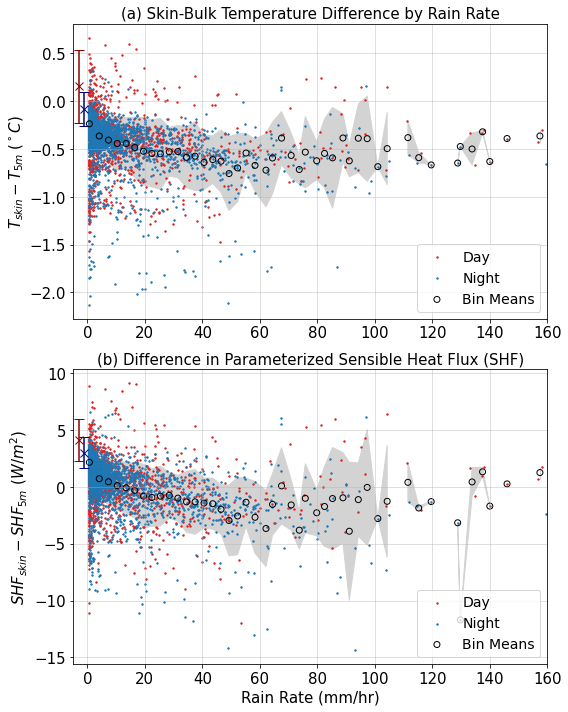

In [69]:
rv_rain_night = rv_night.where(rv_night.P>=0.5)
rv_rain_day = rv_day.where(rv_day.P>=0.5)

rv_dry_night = rv_night.where(rv.P<0.5)
rv_dry_day = rv_day.where(rv.P<0.5)

fontsz = 15

fig,axx = plt.subplots(nrows=2,figsize=(8,10))

#-------------------------------
axx[0].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_bulk_sst+rv_std.skin_bulk_sst), y2=(rv_Pmeans.skin_bulk_sst-rv_std.skin_bulk_sst), color='lightgrey')
# DAY
h1 = axx[0].scatter(rv_rain_day.P, rv_rain_day.skin_bulk_sst,s=2,c='C3')
axx[0].errorbar(-3,rv_dry_day.skin_bulk_sst.mean(), rv_dry_day.skin_bulk_sst.std(),capsize=5, marker='x',color='darkred',markersize=8)
# NIGHT
h2 = axx[0].scatter(rv_rain_night.P, rv_rain_night.skin_bulk_sst,s=2,c='C0')
axx[0].errorbar(-1,rv_dry_night.skin_bulk_sst.mean(), rv_dry_night.skin_bulk_sst.std(),capsize=5, marker='x',color='navy',markersize=8)
# TOTAL BIN MEANS
h3 = axx[0].scatter(rv_Pmeans.P, rv_Pmeans.skin_bulk_sst, edgecolor='k', facecolor='None',zorder=10)
axx[0].grid(alpha=0.5)
axx[0].legend([h1,h2,h3],['Day','Night','Bin Means'],loc='lower right',fontsize=14)

#-------------------------------
axx[1].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_bulk_shf+rv_std.skin_bulk_shf), y2=(rv_Pmeans.skin_bulk_shf-rv_std.skin_bulk_shf), color='lightgrey')
# DAY
axx[1].scatter(rv_rain_day.P, rv_rain_day.skin_bulk_shf,s=2,c='C3')
axx[1].errorbar(-3,rv_dry_day.skin_bulk_shf.mean(), rv_dry_day.skin_bulk_shf.std(),capsize=5, marker='x',color='darkred',markersize=8)
# NIGHT
axx[1].scatter(rv_rain_night.P, rv_rain_night.skin_bulk_shf,s=2,c='C0')
axx[1].errorbar(-1,rv_dry_night.skin_bulk_shf.mean(), rv_dry_night.skin_bulk_shf.std(),capsize=5, marker='x',color='navy',markersize=8)
# TOTAL
axx[1].scatter(rv_Pmeans.P, rv_Pmeans.skin_bulk_shf, edgecolor='k', facecolor='None', zorder=1)
axx[1].grid(alpha=0.5)
axx[1].legend([h1,h2,h3],['Day','Night','Bin Means'],loc='lower right',fontsize=14)

#-------------------------------
axx[1].set_xlabel('Rain Rate (mm/hr)', fontsize=fontsz)
axx[1].set_ylabel('$SHF_{skin} - SHF_{5m}$ ($W/m^2$)', fontsize=fontsz)
axx[0].set_ylabel('$T_{skin} - T_{5m}$ ($^\circ C$)', fontsize=fontsz)

axx[0].set_title('(a) Skin-Bulk Temperature Difference by Rain Rate', fontsize=fontsz)
axx[1].set_title('(b) Difference in Parameterized Sensible Heat Flux (SHF)', fontsize=fontsz)

for axis in axx:
    axis.tick_params(axis='both', which='both', labelsize=fontsz)
    axis.set_xlim([-5,160])

plt.tight_layout()

plt.savefig('../Publication/JGR Submission 1/Figures/Figure_6.png',dpi=300)

### Difference between Skin temp and Wet-bulb temp

In [368]:
def wet_bulb_tw(t, rh):
    #Stull Formula, t in C and rh in %
    a = t * np.arctan(0.151977 * (rh + 8.313659) ** 0.5)
    b = np.arctan(t + rh) - np.arctan(rh - 1.676331)
    c = 0.00391838 * rh ** (1.5) * np.arctan(0.023101 * rh)
    d = -4.686035
    tw = a + b + c + d
    return tw

In [369]:
#calculate differential variables between skin and bulk
rv['wetbulb'] = wet_bulb_tw(rv.T02,rv.RH02)
rv['skin_wetbulb'] = rv.sst_skin - rv.wetbulb

#subset rv to make the groupby_bins operation execute quickly
rv_sub = xr.merge([rv.P, rv.skin_bulk_shf, rv.skin_bulk_sst, rv.skin_wetbulb])
step=3
rv_gb = rv_sub.groupby_bins('P',bins=np.arange(0,160,step))
rv_Pmeans = rv_gb.mean()
#rv_Pq10 = rv_gb.reduce(np.nanquantile, q=0.1)
#rv_Pq90 = rv_gb.reduce(np.nanquantile, q=0.9)
rv_std = rv_gb.std()
#rv_Pcount = rv_gb.count()

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


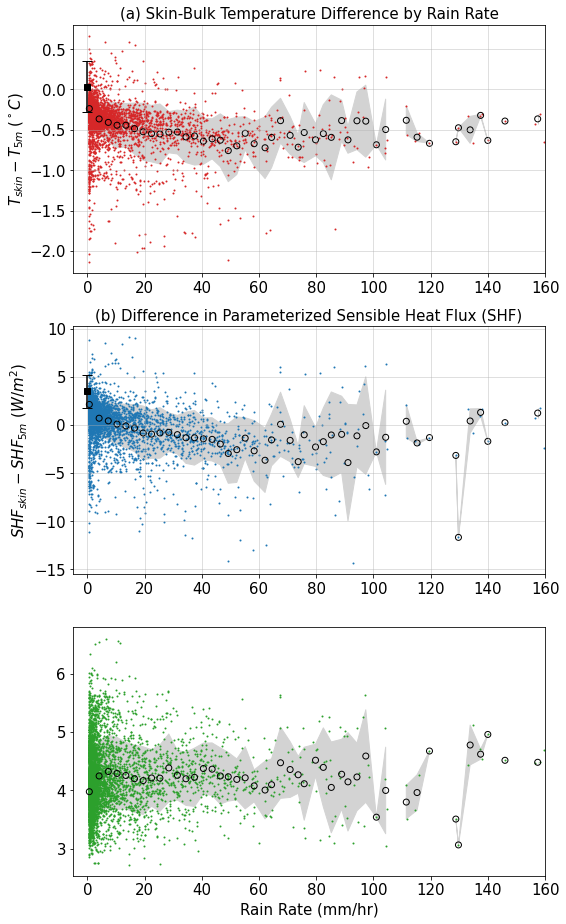

In [372]:
rv_rain = rv.where(rv.P>=0.5)
rv_dry = rv.where(rv.P<0.5)
fontsz = 15

fig,axx = plt.subplots(nrows=3,figsize=(8,13))

axx[0].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_bulk_sst+rv_std.skin_bulk_sst), y2=(rv_Pmeans.skin_bulk_sst-rv_std.skin_bulk_sst), color='lightgrey')
axx[0].scatter(rv_rain.P, rv_rain.skin_bulk_sst,s=1,c='C3')
axx[0].scatter(rv_Pmeans.P, rv_Pmeans.skin_bulk_sst, edgecolor='k', facecolor='None')
axx[0].errorbar(0,rv_dry.skin_bulk_sst.mean(), rv_dry.skin_bulk_sst.std(),capsize=5, marker='s',color='k')
axx[0].grid(alpha=0.5)

axx[1].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_bulk_shf+rv_std.skin_bulk_shf), y2=(rv_Pmeans.skin_bulk_shf-rv_std.skin_bulk_shf), color='lightgrey')
axx[1].scatter(rv_rain.P, rv_rain.skin_bulk_shf,s=1)
axx[1].scatter(rv_Pmeans.P, rv_Pmeans.skin_bulk_shf, edgecolor='k', facecolor='None')
axx[1].grid(alpha=0.5)
axx[1].errorbar(0,rv_dry.skin_bulk_shf.mean(), rv_dry.skin_bulk_shf.std(),capsize=5, marker='s',color='k')

axx[1].set_ylabel('$SHF_{skin} - SHF_{5m}$ ($W/m^2$)', fontsize=fontsz)
axx[0].set_ylabel('$T_{skin} - T_{5m}$ ($^\circ C$)', fontsize=fontsz)

axx[0].set_title('(a) Skin-Bulk Temperature Difference by Rain Rate', fontsize=fontsz)
axx[1].set_title('(b) Difference in Parameterized Sensible Heat Flux (SHF)', fontsize=fontsz)

axx[2].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_wetbulb+rv_std.skin_wetbulb), y2=(rv_Pmeans.skin_wetbulb-rv_std.skin_wetbulb), color='lightgrey')
axx[2].scatter(rv_rain.P, rv_rain.skin_wetbulb,s=1,c='C2')
axx[2].scatter(rv_Pmeans.P, rv_Pmeans.skin_wetbulb, edgecolor='k', facecolor='None')

axx[2].set_xlabel('Rain Rate (mm/hr)', fontsize=fontsz)

for axis in axx:
    axis.tick_params(axis='both', which='both', labelsize=fontsz)
    axis.set_xlim([-5,160])

plt.tight_layout()

#plt.savefig('./Figures/SST and SHF differences as function of Rain Rate v5.png')

## 7. Wind Effects

In [97]:
from RainEvent_Toolbox import extract_composite_event_SS

#generate plot of wind speed bin vs. max delta-sst
δsst_means = []
δsst_stds = []
δTsea_means = []
δTsea_stds = []
sizes = []
wind_bins = np.arange(2,17)

for wind_bin in tqdm.tqdm(wind_bins):
    rain_bin = []
    sst_bin = []

    #loop through each event and determine whether it belongs in this bin
    for rain,sst in zip(rain_event_list,sst_event_list):
        start = pd.to_datetime(rain.attrs['Rain Onset'])
        sst_max = pd.to_datetime(sst.attrs['Time of max δsst'])
        wind_mean = rain.U10.sel(index=slice(start,sst_max)).mean().item()

        if (wind_mean>wind_bin-0.5 and wind_mean<=wind_bin+0.5):
            rain_bin.append(rain)
            sst_bin.append(sst)

    composite_bin = extract_composite_event(rain_event_list = rain_bin, 
                                              sst_event_list = sst_bin, 
                                              param_list = param_list, 
                                              start = -2, 
                                              stop = 7, 
                                              spacing = 0.2,
                                              plotflag = 0,
                                              title = '')

    #calculate mean and std of composite event at maximum δsst
    δsst_mean_bin = composite_bin.δsst.mean(dim='event',skipna=True).sel(index=1).item()
    δsst_std_bin = composite_bin.δsst.std(dim='event',skipna=True).sel(index=1).item()
    
    δsst_means.append(δsst_mean_bin)
    δsst_stds.append(δsst_std_bin)
    
    #calculate mean and std of composite event at maximum δTsea
    δTsea_mean_bin = composite_bin.δTsea.mean(dim='event',skipna=True).sel(index=1).item()
    δTsea_std_bin = composite_bin.δTsea.std(dim='event',skipna=True).sel(index=1).item()
    
    δTsea_means.append(δTsea_mean_bin)
    δTsea_stds.append(δTsea_std_bin)
    
    #calculate how many entries are involved with each event to scale dot sizes
    entries = composite_bin.δsst.sel(index=1).count().values.item()
    
    sizes.append(entries*10)


  7%|█████▌                                                                             | 1/15 [00:00<00:08,  1.71it/s]C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.52it/s]


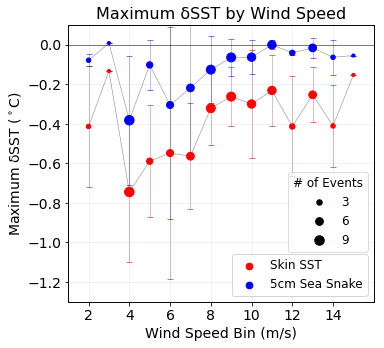

In [102]:
panel_font = 14
title_font = 16
capsz = 3

fig,axx = plt.subplots(figsize=(5.5,5))

axx.errorbar(x=wind_bins, y=δsst_means, yerr=δsst_stds, fmt='-k', ecolor='darkred', linewidth=0.5, capsize=capsz, zorder=100, alpha = 0.5)
h1 = axx.scatter(x=wind_bins, y=δsst_means, s=sizes, c='red',zorder=200)

axx.errorbar(x=wind_bins, y=δTsea_means, yerr=δTsea_stds, fmt='-k', ecolor='darkblue', linewidth=0.5, capsize=capsz, zorder=100, alpha = 0.5)
h2 = axx.scatter(x=wind_bins, y=δTsea_means, s=sizes, c='blue',zorder=200)

#axx.plot(wind_bins,np.zeros(len(wind_bins)),color='k',linewidth = 0.5,zorder=1000)
axx.hlines(y=0,xmin=0,xmax=17,color='k',linewidth = 0.5,zorder=1000)

axx.legend([h1,h2],['Skin SST','5cm Sea Snake'],loc='lower right')

par = axx.twinx()
par.legend(handles = h2.legend_elements("sizes", num=3)[0], labels=['3','6','9'], title='# of Events', bbox_to_anchor=(1,0.49), framealpha=0.7).set_zorder(1000)
par.set_yticks([])

plt.title('Maximum δSST by Wind Speed', fontsize=title_font)

axx.set_xlim([1,16])
axx.set_ylim([-1.3,0.1])

axx.set_xlabel('Wind Speed Bin (m/s)', fontsize=panel_font)
axx.set_ylabel('Maximum δSST ($^\circ$C)', fontsize=panel_font)
axx.xaxis.set_tick_params(labelsize=panel_font)
axx.yaxis.set_tick_params(labelsize=panel_font)

axx.set_xticks([2,4,6,8,10,12,14])
axx.grid(alpha=0.2)

plt.tight_layout()
#plt.savefig('./Figures/Max dSST by Wind Speed v1.png', dpi=300)

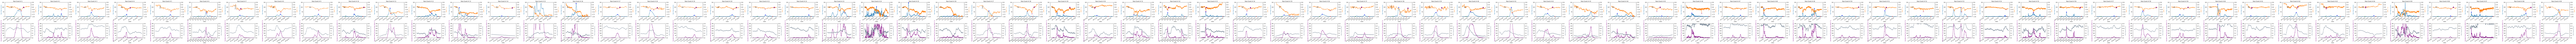

In [77]:
%autoreload
from RainEvent_Toolbox import plot_rain_events
plot_rain_events(rain_event_list = rain_event_list,  
                 sst_event_list = sst_event_list, 
                 rain_ylims = [-1,150],
                 δsst_ylims = [-1,0.5],
                 rhf_ylims = [0,300],
                 wind_ylims = [0,15])
#plt.savefig('./Figures/Dynamo Rain Events + deltaSST + Wind v3.png')

In [119]:
#hand-picking only simplest events
simple_events =  [1,2,4,5,6,8,9, 10,11,13,17,18,   27,32,33,36,40,41,42,      53,58,68,69] #18 & 33 are new, old 20 & 33 & 47 are no good, 
#simple_events = [1,3,5,6,7,9,10,11,12,14,17,19,20,27,32,33,37,42,43,44,47,49,57,60,68]

windmeans = []
sst_recoveries = []
peak_rates = []
event_lengths = []
δssts = []

for event_num in [x-1 for x in simple_events]:
    event_length = (rain_event_list[event_num].attrs['Rain End'] - rain_event_list[event_num].attrs['Rain Onset']).astype('timedelta64[m]').astype('float')
    δsst_max = sst_event_list[event_num].attrs['Max δsst']
    
    #if event_length < 250:
    #if δsst_max < -0.4:
    sst_max = pd.to_datetime(sst_event_list[event_num].attrs['Time of max δsst'])
    sst_rec = pd.to_datetime(sst_event_list[event_num].attrs['Time of sst recovery'])
    wind_mean = rain_event_list[event_num].U10.sel(index=slice(sst_max,sst_rec)).mean().item()
    windmeans.append(wind_mean)

    sst_recoveries.append(sst_event_list[event_num].attrs['Minutes to sst recovery'])

    peak_rates.append(rain_event_list[event_num].attrs['Peak Rate'])

    event_lengths.append(event_length)

    δssts.append(δsst_max)

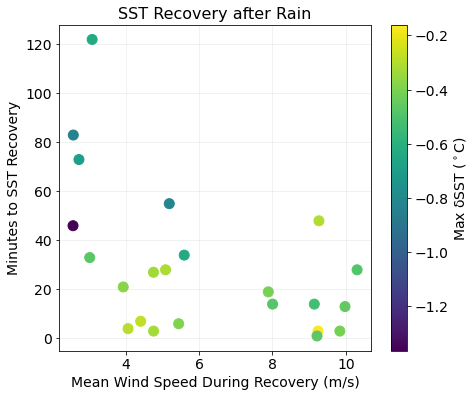

In [120]:
panel_font = 14
title_font = 16

fig,axx = plt.subplots(figsize=(7,6))
h1 = axx.scatter(windmeans,sst_recoveries,c=δssts,s=100)
cbar = plt.colorbar(h1,label='Max δSST ($^\circ$C)')

plt.xlabel('Mean Wind Speed During Recovery (m/s)',fontsize=panel_font)
plt.ylabel('Minutes to SST Recovery',fontsize=panel_font)
axx.xaxis.set_tick_params(labelsize=panel_font)
axx.yaxis.set_tick_params(labelsize=panel_font)
cbar.ax.tick_params(labelsize=panel_font)
cbar.ax.yaxis.label.set_fontsize(panel_font)

plt.title('SST Recovery after Rain',fontsize=title_font)
axx.grid(alpha=0.2)

#plt.savefig('./Figures/Wind Speed vs. Time for SST to Recover after Rain v2.png', dpi=300)

# Combine these two figures into 1 with 2 panels

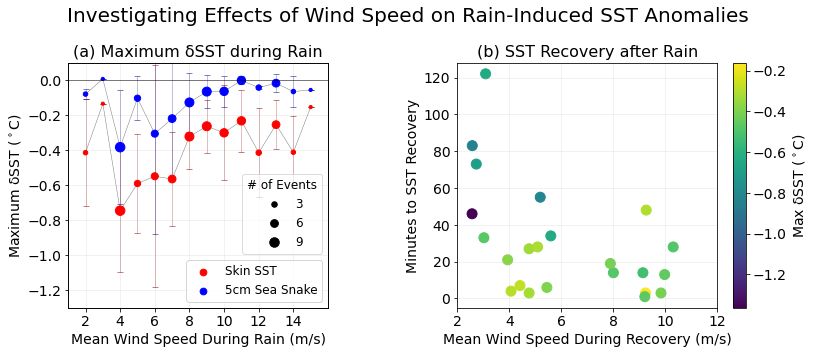

In [125]:
panel_font = 14
title_font = 16
capsz = 3

fig = plt.figure(figsize=(11.5,5))
axx0 = plt.subplot2grid(shape=(5,12),loc=(0,0),rowspan=5,colspan=5)

#---Figure 1: Max SST deviation as a funtion of wind speed---
axx0.errorbar(x=wind_bins, y=δsst_means, yerr=δsst_stds, fmt='-k', ecolor='darkred', linewidth=0.5, capsize=capsz, zorder=100, alpha = 0.5)
h1 = axx0.scatter(x=wind_bins, y=δsst_means, s=sizes, c='red',zorder=200)

axx0.errorbar(x=wind_bins, y=δTsea_means, yerr=δTsea_stds, fmt='-k', ecolor='darkblue', linewidth=0.5, capsize=capsz, zorder=100, alpha = 0.5)
h2 = axx0.scatter(x=wind_bins, y=δTsea_means, s=sizes, c='blue',zorder=200)

axx0.hlines(y=0,xmin=0,xmax=17,color='k',linewidth = 0.5,zorder=1000)

axx0.legend([h1,h2],['Skin SST','5cm Sea Snake'])

par = axx0.twinx()
par.legend(handles = h2.legend_elements("sizes", num=3)[0], labels=['3','6','9'], title='# of Events', bbox_to_anchor=(1,0.57), framealpha=0.7).set_zorder(1000)
par.set_yticks([])

axx0.set_title('(a) Maximum δSST during Rain', fontsize=title_font)

axx0.set_xlim([1,16])
axx0.set_ylim([-1.3,0.1])

axx0.set_xlabel('Mean Wind Speed During Rain (m/s)', fontsize=panel_font)
axx0.set_ylabel('Maximum δSST ($^\circ$C)', fontsize=panel_font)
axx0.xaxis.set_tick_params(labelsize=panel_font)
axx0.yaxis.set_tick_params(labelsize=panel_font)

axx0.set_xticks([2,4,6,8,10,12,14])
axx0.grid(alpha=0.2)

#-----Figure 2: Recovery as a function of wind speed----
axx1 = plt.subplot2grid(shape=(5,12),loc=(0,6),rowspan=5,colspan=6)

h1 = axx1.scatter(windmeans,sst_recoveries,c=δssts,s=100)
cbar = plt.colorbar(h1,ax=axx1,label='Max δSST ($^\circ$C)')

axx1.set_xlabel('Mean Wind Speed During Recovery (m/s)',fontsize=panel_font)
axx1.set_ylabel('Minutes to SST Recovery',fontsize=panel_font)
axx1.xaxis.set_tick_params(labelsize=panel_font)
axx1.yaxis.set_tick_params(labelsize=panel_font)
cbar.ax.tick_params(labelsize=panel_font)
cbar.ax.yaxis.label.set_fontsize(panel_font)
axx1.set_xticks([2,4,6,8,10,12])

axx1.set_title('(b) SST Recovery after Rain',fontsize=title_font)
axx1.grid(alpha=0.2)

plt.suptitle('Investigating Effects of Wind Speed on Rain-Induced SST Anomalies',fontsize=20,y=0.98)

plt.tight_layout()

plt.savefig('../Publication/JGR Submission 1/Figures/Figure_7.png', dpi=300)

## Interim: Wind Direction

(array([ 1785.52863357,  1061.68201126,  1227.30960263,   468.00903558,
          283.27782773,   125.82839931,   203.26815513,   284.40932749,
          379.00937854,   562.78222536,  2961.19854396,  9115.69958237,
         6565.9991741 ,  5373.61639095, 10255.00338254, 10291.92329071,
         8478.88383165, 13106.4504208 ,  8469.0038185 ,  9331.30938798,
         4361.93176606,  2084.971471  ,   949.17694754,   479.1968134 ,
          259.21273756,  1025.59599363,  1573.57667951,  4170.16300351,
         9392.52636371,  7206.55779875,  7994.70651407,  8992.79937937,
        10264.74679208,  7868.89141447,  6452.19966707, 10499.08212503,
        10977.17096448, 13050.44748964, 20477.56739233, 20443.41831543,
        16968.36406008, 11083.32215897, 13344.9058026 , 11070.11314283,
         6062.05539581,  3216.68473039,  1403.63256358,  1303.67112386,
         1033.32502047,  1739.00297579]),
 array([1.74921847e-02, 7.21565318e+00, 1.44138142e+01, 2.16119752e+01,
        2.88101362e+01

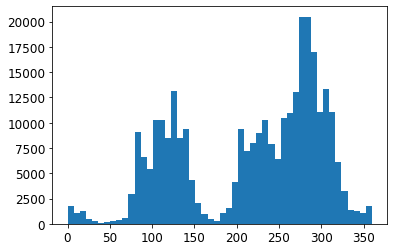

In [59]:
plt.hist(rv.wdirR.where(rv.wspdR > 7), weights=rv.wspdR.where(rv.wspdR > 7), bins=50)

(array([1.309e+03, 3.115e+03, 4.867e+03, 6.970e+03, 7.164e+03, 7.576e+03,
        7.991e+03, 8.101e+03, 7.896e+03, 7.697e+03, 7.648e+03, 7.172e+03,
        6.675e+03, 6.221e+03, 6.458e+03, 6.998e+03, 7.181e+03, 6.553e+03,
        4.919e+03, 3.655e+03, 2.649e+03, 1.558e+03, 9.410e+02, 5.940e+02,
        4.330e+02, 3.670e+02, 3.340e+02, 2.760e+02, 2.350e+02, 1.890e+02,
        1.710e+02, 1.400e+02, 1.160e+02, 1.100e+02, 9.400e+01, 5.800e+01,
        6.300e+01, 4.600e+01, 2.800e+01, 1.000e+01, 1.400e+01, 7.000e+00,
        6.000e+00, 6.000e+00, 5.000e+00, 6.000e+00, 8.000e+00, 6.000e+00,
        6.000e+00, 2.000e+00]),
 array([5.33977819e-03, 4.61461655e-01, 9.17583533e-01, 1.37370541e+00,
        1.82982729e+00, 2.28594916e+00, 2.74207104e+00, 3.19819292e+00,
        3.65431480e+00, 4.11043667e+00, 4.56655855e+00, 5.02268043e+00,
        5.47880231e+00, 5.93492418e+00, 6.39104606e+00, 6.84716794e+00,
        7.30328981e+00, 7.75941169e+00, 8.21553357e+00, 8.67165545e+00,
        9.127777

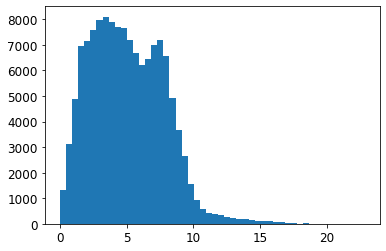

In [57]:
plt.hist(rv.wspdR,bins=50)

## 7. DC Fluxes: Plotting all events

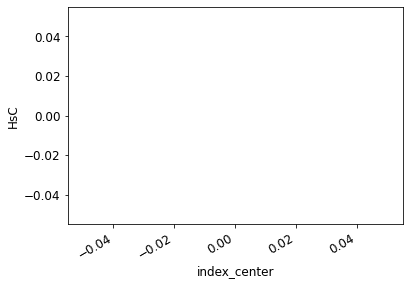

In [26]:
Edson_Fluxes.HsC.sel(index=slice(start,end)).plot()

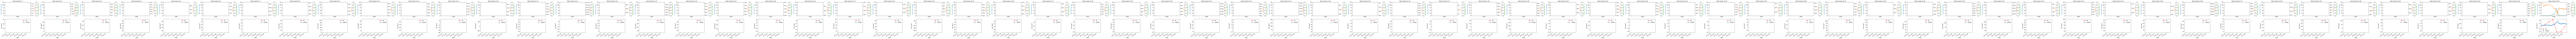

In [33]:
#initialize figure to plot into based on how many rain events we have
figlength = 6*len(rain_event_list)
fig, axx = plt.subplots(nrows=2, ncols=len(rain_event_list),facecolor='w',figsize=(figlength,6),sharex=True)

rain_ylims = [0,125]


for event_num in np.arange(0,len(rain_event_list)):
    
    fig, axx = plt.subplots(nrows=2, ncols=len(rain_event_list),facecolor='w',figsize=(figlength,6),sharex=True)

    start1 = rain_event_list[event_num].isel(index=0).index.values
    end1 = rain_event_list[event_num].isel(index=-1).index.values
    #print(event_num)

    #-----TOP PLOT: Wind Stress, Rain Rate & Solar Insolation----
    #precip rate
    rain_event_list[event_num].P.plot.line(ax=axx[0,event_num],fillstyle=None)
    axx[0,event_num].set_ylabel('Rain Rate [mm/hr]',color='C0')
    axx[0,event_num].set_ylim(rain_ylims)
    #solar flux
    ax11 = axx[0,event_num].twinx()
    ax11.plot(sst_event_list[event_num].sst,color='C1')
    ax11.set_ylabel('SST [$\circ$C]', color='C1')
    #ax11.set_ylim([0,1200])
    #wind stress
    ax1 = axx[0,event_num].twinx()
    offset = 50
    ax1.spines['right'].set_position(('outward',offset))
    rain_event_list[event_num].stress.plot.line(color='green',ax=ax1,fillstyle=None,alpha=0.5,zorder=0)
    ax1.set_ylabel('Wind Stress [N/m^2]',color='green')
    ax1.set_ylim([0,0.5])

    #----BOTTOM PLOT: DC & COARE Fluxes-------
    #ax2 = axx[1,event_num]
    #plot DC flux
    Edson_Fluxes.HsC.sel(index=slice(start1,end1)).plot(color='red',ax=axx[1,event_num],marker='o')
    #plot COARE flux
    rain_event_list[event_num].shf.plot(color='C0',ax=axx[1,event_num],marker='o')
    #legend
    axx[1,event_num].legend(['DC','COARE'])
    axx[1,event_num].set_ylabel('SHF $W/m^2$',color='k')
    axx[1,event_num].set_xlim([start1, end1])
    
    #title
    axx[0,event_num].set_title(f'Rain Event # {event_num+1}')
    
    
plt.tight_layout()

plt.savefig('./Figures/Dynamo Rain Events + DC Fluxes v1.png')

In [39]:
for event_num in tqdm.tqdm(np.arange(0,len(rain_event_list))):
    event = rain_event_list[event_num]
    
    HsC = Edson_Fluxes.HsC.sel(index=slice(event.isel(index=0).index.values,event.isel(index=-1).index.values))
    
    #resample to 1min and fill in any missing gaps
    sst = sst_event_list[event_num].sst.resample(index='1min').mean().interp_like(event)
    sst = sst.where(np.isfinite(sst),drop=True)#.where(event.P != 0, drop=True)
    #event = event.where(np.isfinite(sst),drop=True).where(event.P != 0, drop=True)
    
    
    #------------PLOT AND SAVE---------------------
    fig = plt.figure(figsize=(12,12))
    axx0 = plt.subplot2grid(shape=(3,2),loc=(0,0),rowspan=1,colspan=2)
    
    sst.plot(ax=axx0,color='C0')
    event.TseaTSG.plot(ax=axx0,color='navy')

    axx0.legend(['KT-15','TSG'])
    axx0.set_title(f'Rain Event {event_num+1}')
    axx0.grid()
    axx0.set_ylabel('SST (C)')
    axx0.set_xlabel('')
    
    par0 = axx0.twinx()
    HsC.plot(ax=par0,color='C1',marker='.')
    event.SHF_fromSkin.plot(ax=par0,color='red')
    event.SHF_fromBulk.plot(ax=par0,color='maroon')
    par0.legend(['DC','COARE_skin','COARE_bulk'])
    par0.set_ylabel('SHF (W/m^2)')

    axx1 = plt.subplot2grid(shape=(3,2),loc=(1,0),rowspan=1,colspan=2)
    
    axx1.plot(event.U10,'gray')
    axx1.grid()
    axx1.set_ylabel('Wind Speed (m/s)',color='gray')
    axx1.set_xlabel('time')

    par = axx1.twinx()
    par.plot(event.P,'k')
    par.set_ylabel('Rain Rate (mm/hr)')
    
    par12 = axx1.twinx()
    offset = 50
    par12.spines['right'].set_position(('outward',offset))
    par12.plot(event.T10,color='C2')
    par12.set_ylabel('Air Temperature (C)',color='C2')
    
    plt.tight_layout()
    plt.savefig(f'./Figures/DC Events/Event {event_num+1}.png')
    plt.close()
    


  2%|█▎                                                                                 | 1/65 [00:00<00:47,  1.36it/s]C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.45it/s]


In [38]:
event

<xarray.Dataset>
Dimensions:           (index: 0)
Coordinates:
  * index             (index) datetime64[ns] 
Data variables:
    COG               (index) float64 
    E                 (index) float64 
    Evap              (index) float64 
    Heading           (index) float64 
    IRdn              (index) float64 
    IRup              (index) float64 
    Lat               (index) float64 
    Lon               (index) float64 
    P                 (index) float64 
    Pair10            (index) float64 
    Precip            (index) float64 
    Q02               (index) float64 
    Q10               (index) float64 
    Qsea              (index) float64 
    RH02              (index) float64 
    RH10              (index) float64 
    SOG               (index) float64 
    SSQ               (index) float64 
    SST               (index) float64 
    SalTSG            (index) float64 
    Sclr              (index) float64 
    Smax              (index) float64 
    Solardn      

In [28]:
Edson_Fluxes.HsC.sel(index=slice(rain_event_list[event_num].isel(index=0).index,rain_event_list[event_num].isel(index=-1).index))

<xarray.DataArray 'HsC' (index: 6)>
array([  5.639833,  15.052309,  22.332223, -21.001102, -20.478781,  -2.185753])
Coordinates:
  * index    (index) datetime64[ns] 2011-12-25T01:27:29.950000 ... 2011-12-25T01:52:29.949999992

#### Take a gander at some gradient variables

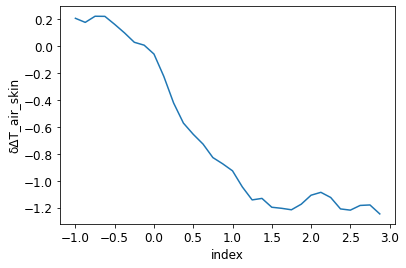

In [17]:
composite_event.δΔT_air_skin.mean(dim='event').plot()

In [18]:
Edson_Fluxes['ΔT_air_skin'] = rv.ΔT_air_skin.rolling(index=5).mean().interp_like(Edson_Fluxes)
Edson_Fluxes['P'] = rv.P.rolling(index=5).mean().interp_like(Edson_Fluxes)

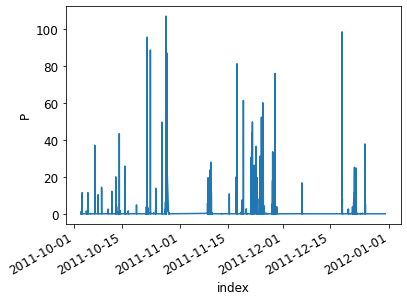

In [19]:
Edson_Fluxes.P.plot()
#rv.P.plot()

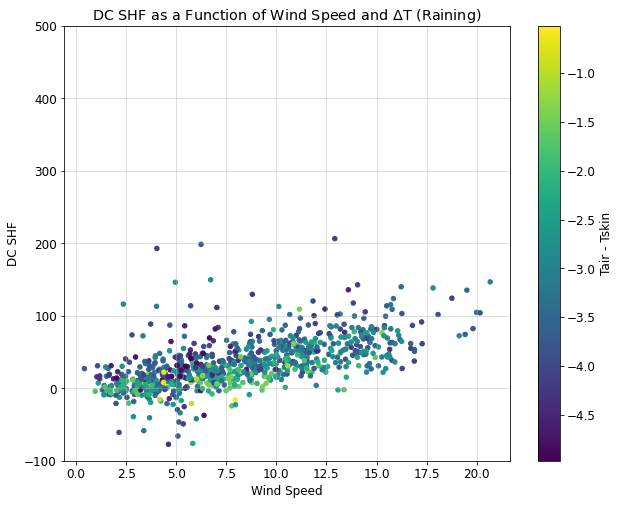

In [20]:
fig = plt.figure(figsize=(10,8))
EF = Edson_Fluxes.where(Edson_Fluxes.P > 0.5)
plt.scatter(EF.U10r, EF.HsC, c=EF.ΔT_air_skin, s=20)
plt.ylim([-100,500])
plt.colorbar(label='Tair - Tskin')
plt.xlabel('Wind Speed')
plt.ylabel('DC SHF')
plt.grid(alpha=0.5)
plt.title('DC SHF as a Function of Wind Speed and $\Delta$T (Raining)')
plt.savefig('./Figures/DC SHF as a Function of Wind Speed and DeltaT v1.png')

In [22]:
EF_sub = xr.merge([EF.P, EF.U10r, EF.ΔT_air_skin, EF.HsC])
EF_sub

<xarray.Dataset>
Dimensions:      (index: 17928)
Coordinates:
  * index        (index) datetime64[ns] 2011-10-03T00:02:29.950000008 ... 2011-12-31T00:57:29.950000
Data variables:
    P            (index) float64 nan nan 1.043 nan nan ... nan nan nan nan nan
    U10r         (index) float64 nan nan 7.95 nan nan ... nan nan nan nan nan
    ΔT_air_skin  (index) float64 nan nan -0.5161 nan nan ... nan nan nan nan nan
    HsC          (index) float64 nan nan -15.94 nan nan ... nan nan nan nan nan

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\groupby.py:717: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass d

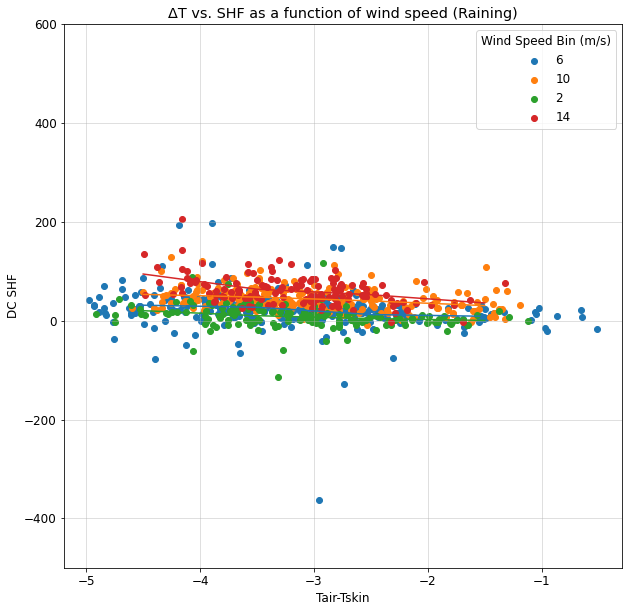

In [23]:
step=4
EF_gb = EF_sub.groupby_bins('U10r',bins=np.arange(0,20,step))

fig,axx=plt.subplots(figsize=(10,10))
handles = []
for wspd,group in EF_gb:
    h = axx.scatter(group.ΔT_air_skin,group.HsC)
    handles.append(h)
    dT_gb = group.groupby_bins('ΔT_air_skin',bins=np.arange(-5,0))
    dT_mean = dT_gb.mean()
    axx.plot(np.arange(-4,0)-0.5,dT_mean.HsC)
    
plt.ylim([-500,600])
plt.title('ΔT vs. SHF as a function of wind speed (Raining)')
plt.legend(handles,[int(key.mid) for key,group in EF_gb],title='Wind Speed Bin (m/s)')
plt.xlabel('Tair-Tskin')
plt.ylabel('DC SHF')
plt.grid(alpha=0.5)
plt.savefig('./Figures/DeltaT vs DC SHF by Wind v1.png')

#### Figure looking specifically at DC fluxes

Want to show difference between COARE run with skin temp vs. COARE run with TSG temp - gives us a sense of the magnitude of the surface cooling effect on turbulent fluxes. Then compare this with the observed DC fluxes.

Maybe a composite-event style delta-timeseries plot of the two COARE options and the DC, plus a COAREskin vs DC scatterplot for every actual data point?

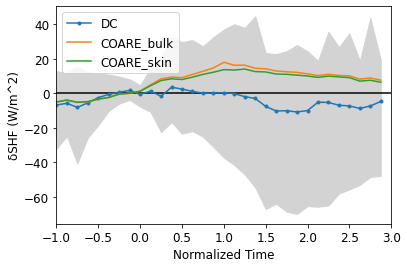

In [33]:
means_DC = composite_event.where(~np.isnan(composite_event.δHsC)).mean(dim='event',skipna=True)
q10_DC = composite_event.where(~np.isnan(composite_event.δHsC)).quantile(0.1,dim='event')
q90_DC = composite_event.where(~np.isnan(composite_event.δHsC)).quantile(0.9,dim='event')



plt.fill_between(x=means_DC.index,y1=q10_DC.δHsC, y2=q90_DC.δHsC, color='lightgrey')
means_DC.δHsC.plot(marker='.')
means_DC.δSHF_fromBulk.plot()
means_DC.δSHF_fromSkin.plot()
plt.plot([-1,3],[0,0],'k',zorder=1)
plt.xlim([-1,3])
plt.legend(['DC','COARE_bulk','COARE_skin'])
plt.ylabel('δSHF (W/m^2)')
plt.xlabel('Normalized Time')
plt.savefig('./Figures/delta_SHF DC vs COARE v1.png')

In [252]:
# import DC fluxes and add to Revelle dataset
#load file as a dictionary of numpy arrays using the scipy loadmat function
Edson_raw = loadmat('../Data/Level_1/Dynamo/DC Fluxes From Edson (with closed path)/Transfer_D10.mat')
#drop the metadata keys from the dictionary so that all the remaining arrays are the same size
del Edson_raw['__header__']
del Edson_raw['__version__']
del Edson_raw['__globals__']
del Edson_raw['D']
del Edson_raw['zi']
del Edson_raw['zq']
del Edson_raw['zt']
del Edson_raw['zu']
del Edson_raw['cpa']
del Edson_raw['lstatchk']
del Edson_raw['uklMeas']
del Edson_raw['uklsave']
year = 2011
date = datetime.datetime(year, 1, 1) + pd.to_timedelta(Edson_raw['yday'][0]-1,unit='days')
Edson_Fluxes_10 = pd.DataFrame(index=date)
#iterate over each key in the dict and add to the pandas dataframe as a new column
for key in Edson_raw:
    #print(key)
    Edson_Fluxes_10[key] = Edson_raw[key][0].tolist()
Edson_Fluxes_10 = Edson_Fluxes_10.to_xarray()

#interpolate coare outputs onto DC timestamps
Edson_Fluxes_10['Hl_bulk'] = rv.lhf.interp_like(Edson_Fluxes_10,method='linear')

#calculate closed-path sensible heat flux
ρ = Edson_Fluxes_10.rhoair #[kg/m^3]
LE = 2260               #[kJ/kg]
q = Edson_Fluxes_10.Qair   #[g/kg]
T = Edson_Fluxes_10.Tair + 273.15   #[C] -> [K]
wTs = Edson_Fluxes_10.WTr  #[m/s K]

#calculate w'q' from COARE Latent Heat Flux output
wq = Edson_Fluxes_10.Hl_bulk/ρ/LE/1000

#calculate Sensible Heat Flux
wT = (wTs - 0.518*T*wq) / (1 + 0.518*(q/1000))   # ( [m/s K] - [K][m/s][g/g] ) / [g/g] ) -> [m/s][K]
cp = 1.005 + 1.82*q/1000 #[J/g K]
HsC = ρ*cp*wT*1000 
Edson_Fluxes_10['HsC'] = HsC

In [253]:
# import DC fluxes and add to Revelle dataset
#load file as a dictionary of numpy arrays using the scipy loadmat function
Edson_raw = loadmat('../Data/Level_1/Dynamo/DC Fluxes From Edson (with closed path)/Transfer_D20.mat')
#drop the metadata keys from the dictionary so that all the remaining arrays are the same size
del Edson_raw['__header__']
del Edson_raw['__version__']
del Edson_raw['__globals__']
del Edson_raw['D']
del Edson_raw['zi']
del Edson_raw['zq']
del Edson_raw['zt']
del Edson_raw['zu']
del Edson_raw['cpa']
del Edson_raw['lstatchk']
del Edson_raw['uklMeas']
del Edson_raw['uklsave']
year = 2011
date = datetime.datetime(year, 1, 1) + pd.to_timedelta(Edson_raw['yday'][0]-1,unit='days')
Edson_Fluxes_20 = pd.DataFrame(index=date)
#iterate over each key in the dict and add to the pandas dataframe as a new column
for key in Edson_raw:
    #print(key)
    Edson_Fluxes_20[key] = Edson_raw[key][0].tolist()
Edson_Fluxes_20 = Edson_Fluxes_20.to_xarray()

#interpolate coare outputs onto DC timestamps
Edson_Fluxes_20['Hl_bulk'] = rv.lhf.interp_like(Edson_Fluxes_20,method='linear')

#calculate closed-path sensible heat flux
ρ = Edson_Fluxes_20.rhoair #[kg/m^3]
LE = 2260               #[kJ/kg]
q = Edson_Fluxes_20.Qair   #[g/kg]
T = Edson_Fluxes_20.Tair + 273.15   #[C] -> [K]
wTs = Edson_Fluxes_20.WTr  #[m/s K]

#calculate w'q' from COARE Latent Heat Flux output
wq = Edson_Fluxes_20.Hl_bulk/ρ/LE/1000

cp = 1.005 + 1.82*(q/1000) #[J/g K]

#calculate Sensible Heat Flux
wT = (wTs - 0.518*T*wq) / (1 + 0.518*(q/1000))   # ( [m/s K] - [K][m/s][g/g] ) / [g/g] ) -> [m/s][K]

HsC = ρ*cp*wT*1000 
Edson_Fluxes_20['HsC'] = HsC


Text(0, 0.5, 'W/m^2')

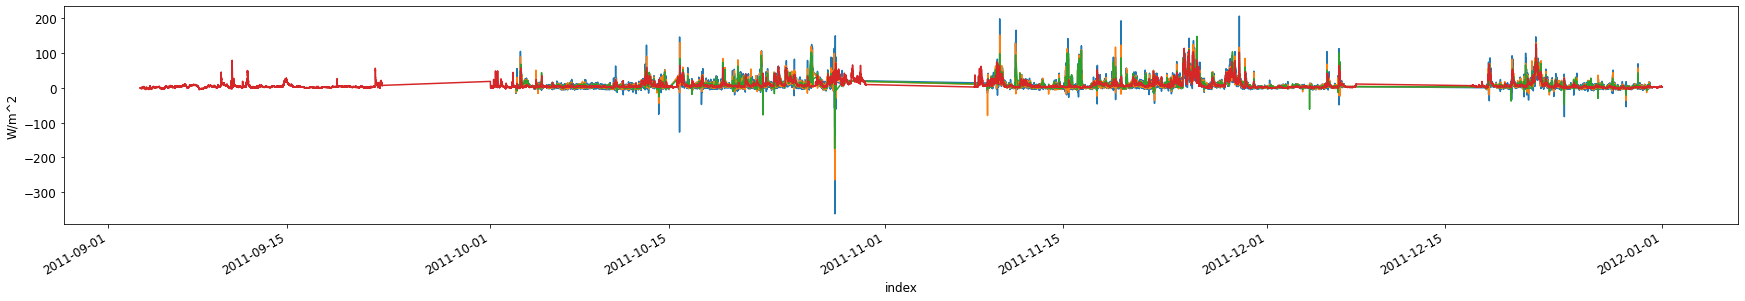

In [255]:
plt.figure(figsize=(30,4))
Edson_Fluxes.HsC.plot()
Edson_Fluxes_10.HsC.plot()
Edson_Fluxes_20.HsC.plot()
#Edson_Fluxes_20.HsC_TEST.plot()
rv.SHF_fromBulk.plot()
#plt.ylim(-10,500)
#plt.xlim(['2011-12-18','2011-12-31'])

plt.ylabel('W/m^2')
#plt.legend(['5min DC','10min DC','20min DC','COARE'])
#plt.savefig('./Figures/DC vs COARE example timeseries.png')

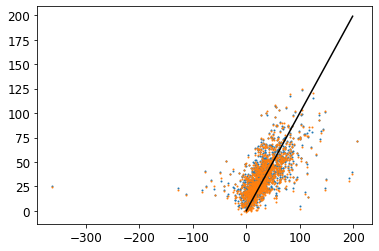

In [256]:
rv5 = rv.reindex_like(Edson_Fluxes,method='nearest')
plt.scatter(Edson_Fluxes.HsC.where(rv5.P!=0),rv5.SHF_fromSkin.where(rv5.P!=0),c='C0',s=1)
plt.scatter(Edson_Fluxes.HsC.where(rv5.P!=0),rv5.SHF_fromBulk.where(rv5.P!=0),c='C1',s=1)

plt.plot(np.arange(0,200),np.arange(0,200),'k')

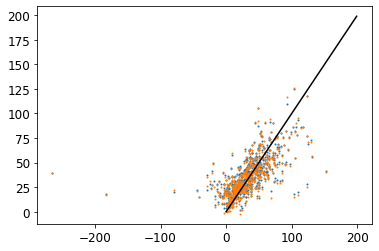

In [262]:
rv10 = rv.reindex_like(Edson_Fluxes_10,method='nearest')
plt.scatter(Edson_Fluxes_10.HsC.where(rv10.P!=0),rv10.SHF_fromSkin.where(rv10.P!=0),c='C0',s=1)
plt.scatter(Edson_Fluxes_10.HsC.where(rv10.P!=0),rv10.SHF_fromBulk.where(rv10.P!=0),c='C1',s=1)

plt.plot(np.arange(0,200),np.arange(0,200),'k')

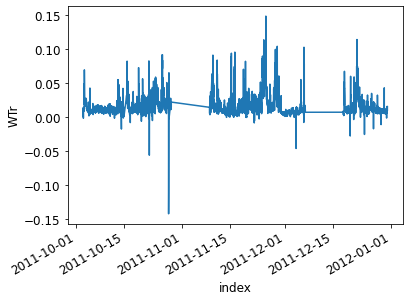

In [197]:
Edson_Fluxes_20.WTr.plot()

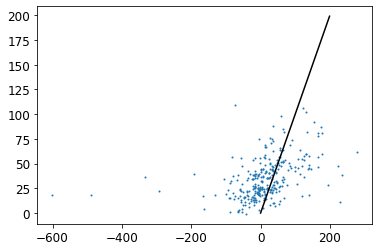

In [216]:
rv20 = rv.reindex_like(Edson_Fluxes_20,method='nearest')
plt.scatter(Edson_Fluxes_20.HsC_new.where(rv20.P!=0),rv20.SHF_fromBulk.where(rv20.P!=0),c='C0',s=1)
#plt.scatter(Edson_Fluxes_20.WTr.where(rv20.P!=0),rv20.SHF_fromBulk.where(rv20.P!=0),c='C1',s=1)

plt.plot(np.arange(0,200),np.arange(0,200),'k')

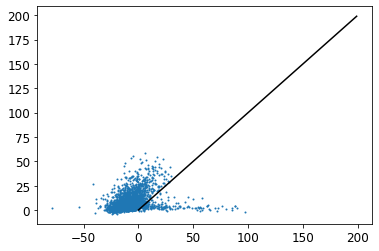

In [235]:
rv20 = rv.reindex_like(Edson_Fluxes_20,method='nearest')
plt.scatter(Edson_Fluxes_20.HsC_new.where(rv20.P==0),rv20.SHF_fromBulk.where(rv20.P==0),c='C0',s=1)
#plt.scatter(Edson_Fluxes_20.WTr.where(rv20.P!=0),rv20.SHF_fromBulk.where(rv20.P!=0),c='C1',s=1)

plt.plot(np.arange(0,200),np.arange(0,200),'k')

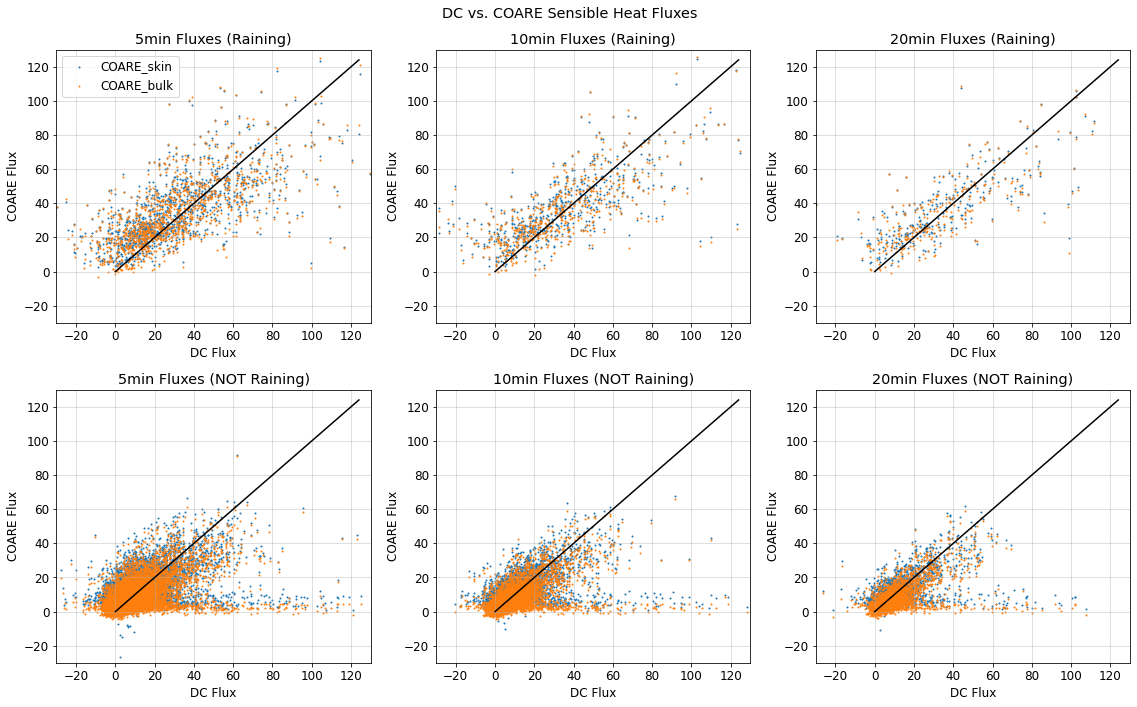

In [263]:
fig, axx = plt.subplots(nrows=2,ncols=3, figsize=(16
                                                  ,10))

axx[0,0].scatter(Edson_Fluxes.HsC.where(rv5.P!=0),rv5.SHF_fromSkin.where(rv5.P!=0),c='C0',s=1)
axx[0,0].scatter(Edson_Fluxes.HsC.where(rv5.P!=0),rv5.SHF_fromBulk.where(rv5.P!=0),c='C1',s=1)
axx[0,0].legend(['COARE_skin','COARE_bulk'])
axx[0,0].set_title('5min Fluxes (Raining)')

axx[0,1].scatter(Edson_Fluxes_10.HsC.where(rv10.P!=0),rv10.SHF_fromSkin.where(rv10.P!=0),c='C0',s=1)
axx[0,1].scatter(Edson_Fluxes_10.HsC.where(rv10.P!=0),rv10.SHF_fromBulk.where(rv10.P!=0),c='C1',s=1)
axx[0,1].set_title('10min Fluxes (Raining)')

axx[0,2].scatter(Edson_Fluxes_20.HsC.where(rv20.P!=0),rv20.SHF_fromSkin.where(rv20.P!=0),c='C0',s=1)
axx[0,2].scatter(Edson_Fluxes_20.HsC.where(rv20.P!=0),rv20.SHF_fromBulk.where(rv20.P!=0),c='C1',s=1)
axx[0,2].set_title('20min Fluxes (Raining)')

axx[1,0].scatter(Edson_Fluxes.HsC.where(rv5.P==0),rv5.SHF_fromSkin.where(rv5.P==0),c='C0',s=1)
axx[1,0].scatter(Edson_Fluxes.HsC.where(rv5.P==0),rv5.SHF_fromBulk.where(rv5.P==0),c='C1',s=1)
axx[1,0].set_title('5min Fluxes (NOT Raining)')

axx[1,1].scatter(Edson_Fluxes_10.HsC.where(rv10.P==0),rv10.SHF_fromSkin.where(rv10.P==0),c='C0',s=1)
axx[1,1].scatter(Edson_Fluxes_10.HsC.where(rv10.P==0),rv10.SHF_fromBulk.where(rv10.P==0),c='C1',s=1)
axx[1,1].set_title('10min Fluxes (NOT Raining)')

axx[1,2].scatter(Edson_Fluxes_20.HsC.where(rv20.P==0),rv20.SHF_fromSkin.where(rv20.P==0),c='C0',s=1)
axx[1,2].scatter(Edson_Fluxes_20.HsC.where(rv20.P==0),rv20.SHF_fromBulk.where(rv20.P==0),c='C1',s=1)
axx[1,2].set_title('20min Fluxes (NOT Raining)')

for axlist in axx:
    for axis in axlist:
        axis.set_xlabel('DC Flux')
        axis.set_ylabel('COARE Flux')
        axis.set_xlim([-30,130])
        axis.set_ylim([-30,130])
        axis.grid(alpha=0.5)
        axis.plot(np.arange(0,125),np.arange(0,125),'k')
        
fig.suptitle('DC vs. COARE Sensible Heat Fluxes')
plt.tight_layout()
plt.savefig('./Figures/DC vs. COARE Sensible Fluxes v2.png')

Text(0, 0.5, 'Hs(skin) - Hs(bulk)')

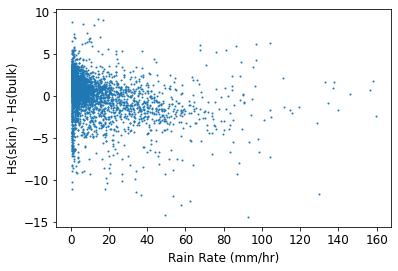

In [38]:
rv['skin_bulk_shf'] = rv.SHF_fromSkin - rv.SHF_fromBulk

plt.scatter(rv.P.where(rv.P>0.5), rv.skin_bulk_shf.where(rv.P>0.5),s=1)

plt.xlabel('Rain Rate (mm/hr)')
plt.ylabel('Hs(skin) - Hs(bulk)')

(25.0, 35.0)

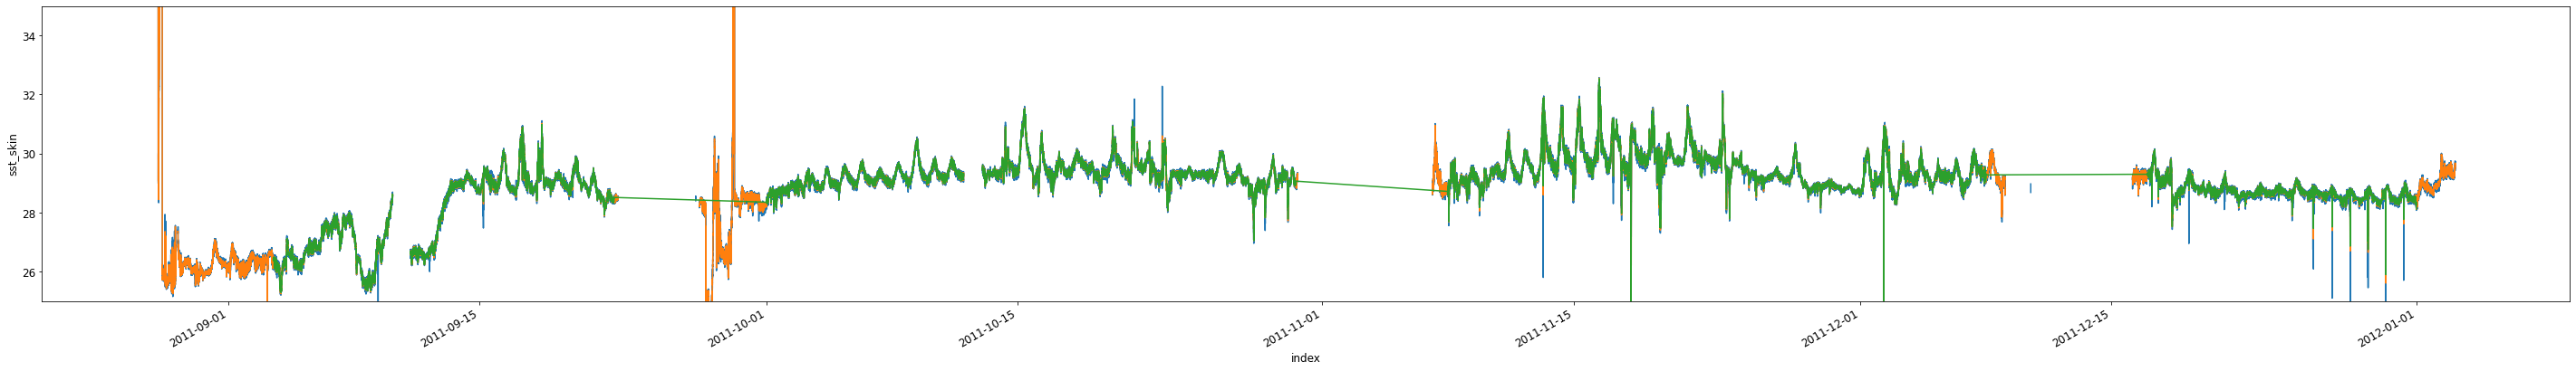

In [39]:
rv['skin_bulk_shf'] = rv.SHF_fromSkin - rv.SHF_fromBulk

#take 1 minute rolling mean and then cast onto rv timestamps
rv['sst_skin'] = kt_10s.rolling(index=6).mean().interp_like(rv,method='linear')

rv['skin_bulk_sst'] = rv.sst_skin - rv.TseaTSG 

plt.figure(figsize=(50,6))

kt_10s.plot()
kt_10s.rolling(index=6).mean().plot()
rv.sst_skin.plot()
plt.ylim([25,35])

In [40]:
rv_sub

<xarray.Dataset>
Dimensions:        (index: 134644)
Coordinates:
  * index          (index) datetime64[ns] 2011-09-03T12:00:00 ... 2012-01-01
Data variables:
    P              (index) float64 0.4143 0.4213 0.4286 0.4286 ... 0.0 0.0 0.0
    skin_bulk_shf  (index) float64 4.674 5.387 5.245 ... 2.001 1.392 0.7409
    skin_bulk_sst  (index) float64 0.05909 0.07404 0.08557 ... -0.2641 -0.3255

In [ ]:
rv.where(rv.P<0.5)

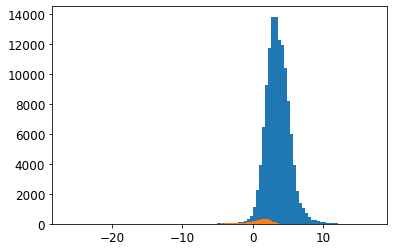

In [94]:
plt.hist(,bins=100);
plt.hist(rv.skin_bulk_shf.where(rv.P>0.5),bins=100);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [347]:
binsize=1 #size in mm/hr
rainbins = np.digitize(rv.P.where(rv.P>0.5),bins=np.arange(0,max(rv.P),binsize))

In [357]:
rv['rainbins'] = rainbins

In [360]:
len(rv.index)

134644

In [355]:
binmeans = rv.groupby(rv.rainbins).skin_bulk_shf.transform('mean')
binmeans

AttributeError: 'DatasetGroupBy' object has no attribute 'skin_bulk_shf'

Text(0, 0.5, 'Hs(skin) - Hs(bulk)')

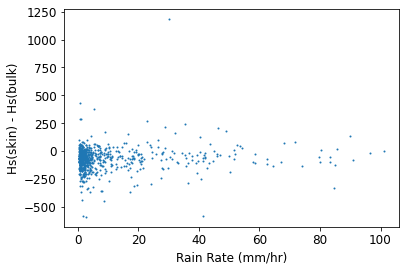

In [338]:
dc_skin_shf = rv5.SHF_fromSkin - Edson_Fluxes.HsC

plt.scatter(rv5.P.where(rv5.P>0.5), dc_skin_shf.where(rv5.P>0.5),s=1)

plt.xlabel('Rain Rate (mm/hr)')
plt.ylabel('Hs(skin) - Hs(bulk)')

Plot DC fluxes for every event for inspection

In [34]:
for event_num in tqdm.tqdm(np.arange(0,len(rain_event_list))):
    event = rain_event_list[event_num]
    #resample to 1min and fill in any missing gaps
    sst = sst_event_list[event_num].sst.resample(index='1min').mean().interp_like(event)
    sst = sst.where(np.isfinite(sst),drop=True).where(event.P != 0, drop=True)
    event = event.where(np.isfinite(sst),drop=True).where(event.P != 0, drop=True)

    #------------PLOT AND SAVE---------------------
    fig = plt.figure(figsize=(12,12))
    axx0 = plt.subplot2grid(shape=(3,2),loc=(0,0),rowspan=1,colspan=2)
    
    sst.plot(ax=axx0,color='C0')
    event.TseaTSG.plot(ax=axx0,color='navy')

    axx0.legend(['KT-15','TSG'])
    axx0.set_title(f'Rain Event {event_num+1}')
    axx0.grid()
    axx0.set_ylabel('SST (C)')
    axx0.set_xlabel('')
    
    par0 = axx0.twinx()
    event.HsC.plot(ax=par0,color='C1')
    event.SHF_fromSkin.plot(ax=par0,color='red')
    event.SHF_fromBulk.plot(ax=par0,color='maroon')
    par0.legend(['DC','COARE_skin','COARE_bulk'])

    axx1 = plt.subplot2grid(shape=(3,2),loc=(1,0),rowspan=1,colspan=2)
    
    axx1.plot(event.U10,'gray')
    axx1.grid()
    axx1.set_ylabel('Wind Speed (m/s)',color='gray')
    axx1.set_xlabel('time')

    par = axx1.twinx()
    par.plot(event.P,'k')
    par.set_ylabel('Rain Rate (mm/hr)')
    
    par12 = axx1.twinx()
    offset = 50
    par12.spines['right'].set_position(('outward',offset))
    par12.plot(event.T10,color='C2')
    par12.set_ylabel('Air Temperature (C)',color='C2')
    
    if event_num !=1:
        axx21 = plt.subplot2grid(shape=(3,2),loc=(2,0),rowspan=1,colspan=1)
        diff_plot(event.HsC, event.SHF_fromSkin, event.P, axis=axx21, cmap='viridis', marker='o', size=20)
        axx21.set_title('DC vs. COARE_skin')

        axx22 = plt.subplot2grid(shape=(3,2),loc=(2,1),rowspan=1,colspan=1)
        diff_plot(event.HsC, event.SHF_fromBulk, event.P, axis=axx22, cmap='viridis', marker='o', size=20)
        axx22.set_title('DC vs. COARE_bulk')
    
        for axis in [axx21, axx22]:
            axis.set_ylabel('Observed - Modeled SST')
            axis.set_xlabel('Observed SST (KT-15)')
            axis.grid(alpha=0.5)
            #axis.set_ylim([-1.5,1.5])

    
    plt.tight_layout()
    plt.savefig(f'./Figures/DC Events/Event {event_num+1}.png')
    plt.close()
    

  0%|                                                                                           | 0/65 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: All-NaN slice encountered
  
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite val

In [281]:
composite_event.δHsC.where(~np.isnan(composite_event.δHsC)).mean(dim='index',skipna=True).dropna(dim='event').event

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'event' (event: 55)>
array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62])
Coordinates:
  * event    (event) int32 8 9 10 11 12 13 14 15 16 ... 55 56 57 58 59 60 61 62

In [68]:
num_list = []
time_list = []
sst_list = []
shf_DC_list = []
shf_fromSkin_list = []
shf_fromBulk_list = []
p_list = []


for event_num in np.arange(len(rain_event_list)):
    if event_num not in exclude:
        event = rain_event_list[event_num]
        #resample to 1min and fill in any missing gaps
        sst = sst_event_list[event_num].sst.resample(index='1min').mean().interp_like(event)
        sst = sst.where(np.isfinite(sst),drop=True).where(event.P > 0.5, drop=True)
        event = event.where(np.isfinite(sst),drop=True).where(event.P >0.5, drop=True)

        num_list.append(event_num*np.ones_like(sst.values))
        time_list.append(event.index.values)
        sst_list.append(sst.values)
        p_list.append(event.P.values)
        
        shf_DC_list = []
        shf_fromSkin_list = []
        shf_fromBulk_list = []

    
event_nums = np.concatenate(num_list)
time = np.concatenate(time_list)
sst = np.concatenate(sst_list)
t_int = np.concatenate(t_int_list)
t_int_vF = np.concatenate(t_int_vF_list)
t_int_SS = np.concatenate(t_int_SS_list)
t_int_vF_SS = np.concatenate(t_int_vF_SS_list)
sst_raincoare = np.concatenate(sst_raincoare_list)
sst_raincoare_SS = np.concatenate(sst_raincoare_SS_list)
sst_coare = np.concatenate(sst_coare_list)
sst_coare_SS = np.concatenate(sst_coare_SS_list)
sw = np.concatenate(sw_list)
p = np.concatenate(p_list)

#### Figure Comparing Model & Observations
Compare KT-15 Observed and Modeled (SS and TSG-fed, Modified & Original Bellenger and COARE) SST at every timestep. X-axis observed, Y-axis modeled.

In [164]:
def diff_plot(observed, modeled, color, axis, cmap, marker, size):
    observed  = np.asarray(observed)
    modeled   = np.asarray(modeled)
    diff      = modeled - observed                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.nanstd(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 2*sd
    CI_high   = md + 2*sd

    axis.scatter(observed, diff, c=color, s=size, cmap=cmap, marker=marker)
    axis.axhline(md,           color='black', linestyle='-')
    axis.axhline(md + 2*sd, color='gray', linestyle='--')
    axis.axhline(md - 2*sd, color='gray', linestyle='--')
    xtext = np.nanmax(observed)#*1.001
    axis.text(x=xtext+0.15,y=md-0.04,s='Mean')
    axis.text(x=xtext+0.15,y=md-0.04 + 2*sd, s='+2σ', color='gray')
    axis.text(x=xtext+0.15,y=md-0.04 - 2*sd, s='-2σ', color='gray')
    axis.text(x=xtext+0.1,y=1.3, s=f'{md.round(3)} $\pm$ {sd.round(3)}', ha='right')


In [68]:
num_list = []
time_list = []
sst_list = []
t_int_list = []
t_int_vF_list = []
t_int_SS_list = []
t_int_vF_SS_list = []
sst_raincoare_list = []
sst_raincoare_SS_list = []
sst_coare_list = []
sst_coare_SS_list = []
sw_list =[]
p_list = []


for event_num in np.arange(len(rain_event_list)):
    if event_num not in exclude:
        event = rain_event_list[event_num]
        #resample to 1min and fill in any missing gaps
        sst = sst_event_list[event_num].sst.resample(index='1min').mean().interp_like(event)
        sst = sst.where(np.isfinite(sst),drop=True).where(event.P > 0.5, drop=True)
        event = event.where(np.isfinite(sst),drop=True).where(event.P >0.5, drop=True)

        num_list.append(event_num*np.ones_like(sst.values))
        time_list.append(event.index.values)
        sst_list.append(sst.values)
        t_int_list.append(event.t_int.values)
        t_int_vF_list.append(event.t_int_vF.values)
        t_int_SS_list.append(event.t_int_SS.values)
        t_int_vF_SS_list.append(event.t_int_vF_SS.values)

        p_list.append(event.P.values)
        sw_list.append(event.Solardn.values)

        sst_raincoare_list.append(event.SSTrain_fromBulk.values)
        sst_raincoare_SS_list.append(event.SSTrain.values)
        sst_coare_list.append(event.SST_fromBulk.values)
        sst_coare_SS_list.append(event.SST.values)
    
event_nums = np.concatenate(num_list)
time = np.concatenate(time_list)
sst = np.concatenate(sst_list)
t_int = np.concatenate(t_int_list)
t_int_vF = np.concatenate(t_int_vF_list)
t_int_SS = np.concatenate(t_int_SS_list)
t_int_vF_SS = np.concatenate(t_int_vF_SS_list)
sst_raincoare = np.concatenate(sst_raincoare_list)
sst_raincoare_SS = np.concatenate(sst_raincoare_SS_list)
sst_coare = np.concatenate(sst_coare_list)
sst_coare_SS = np.concatenate(sst_coare_SS_list)
sw = np.concatenate(sw_list)
p = np.concatenate(p_list)

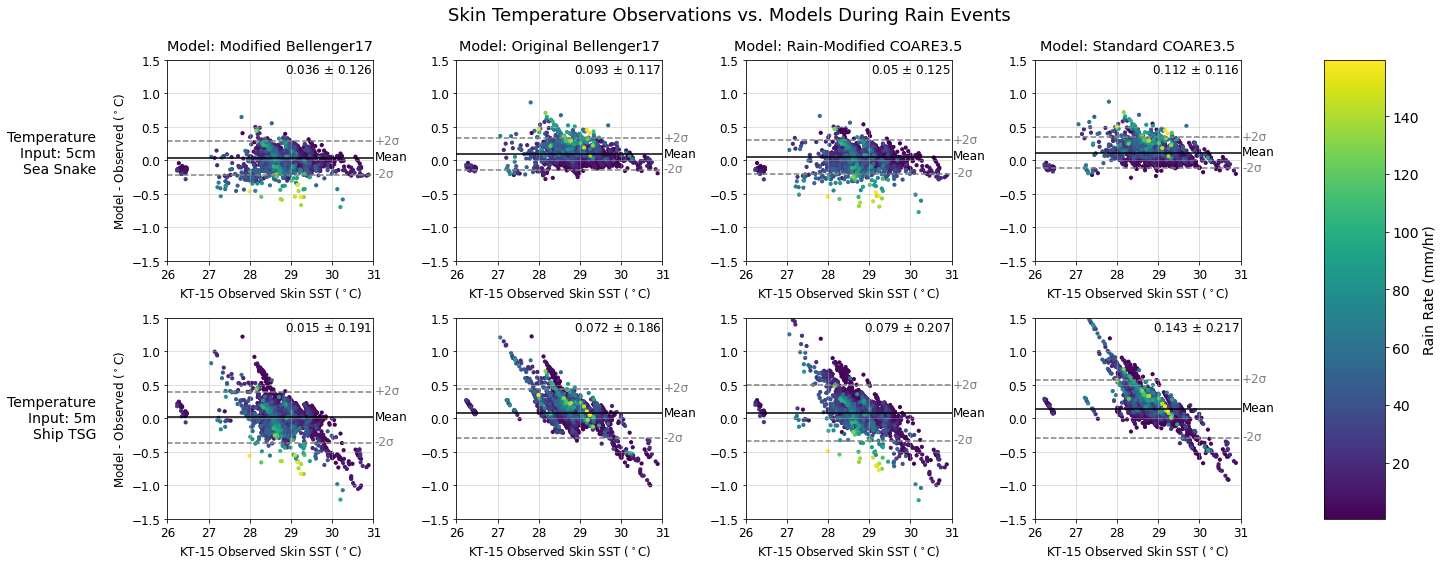

In [168]:
#make version of this figure that is 2 rows (SS or TSG) and 4 columns (ModBel, OrigBel, ModCOARE, OrigCOARE) plus a colorbar on the right and text labels on the left
fig = plt.figure(figsize=(20,8))

axx00 = plt.subplot2grid(shape=(2,10),loc=(0,1),rowspan=1,colspan=2)
axx01 = plt.subplot2grid(shape=(2,10),loc=(0,3),rowspan=1,colspan=2)
axx02 = plt.subplot2grid(shape=(2,10),loc=(0,5),rowspan=1,colspan=2)
axx03 = plt.subplot2grid(shape=(2,10),loc=(0,7),rowspan=1,colspan=2)
axx10 = plt.subplot2grid(shape=(2,10),loc=(1,1),rowspan=1,colspan=2)
axx11 = plt.subplot2grid(shape=(2,10),loc=(1,3),rowspan=1,colspan=2)
axx12 = plt.subplot2grid(shape=(2,10),loc=(1,5),rowspan=1,colspan=2)
axx13 = plt.subplot2grid(shape=(2,10),loc=(1,7),rowspan=1,colspan=2)
axxcb = plt.subplot2grid(shape=(2,10),loc=(0,9),rowspan=2,colspan=1)

cmap = mpl.cm.viridis
marker = 'o'
size = 10

#sort the plotting order by precip amount so that we see all the high-precip values on top in the scatterplots
order = np.argsort(p)

diff_plot(sst[order], t_int_SS[order], p[order], axis=axx00, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], t_int_vF_SS[order], p[order], axis=axx01, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], sst_raincoare_SS[order], p[order], axis=axx02, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], sst_coare_SS[order], p[order], axis=axx03, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], t_int[order], p[order], axis=axx10, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], t_int_vF[order], p[order], axis=axx11, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], sst_raincoare[order], p[order], axis=axx12, cmap=cmap, marker=marker, size=size)
diff_plot(sst[order], sst_coare[order], p[order], axis=axx13, cmap=cmap, marker=marker, size=size)

norm = mpl.colors.Normalize(vmin = p.min(), vmax=p.max())
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=axxcb)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='Rain Rate (mm/hr)', fontsize=14)

pad=10
axx00.set_title('Model: Modified Bellenger17', pad=pad)
axx01.set_title('Model: Original Bellenger17', pad=pad)
axx02.set_title('Model: Rain-Modified COARE3.5', pad=pad)
axx03.set_title('Model: Standard COARE3.5', pad=pad)

plt.suptitle('Skin Temperature Observations vs. Models During Rain Events',fontsize=18)#,y=0.95)
    
axx00.set_ylabel('Model - Observed ($^\circ$C)')
axx10.set_ylabel('Model - Observed ($^\circ$C)')

for axis in [axx00,axx01,axx02,axx03,axx10,axx11,axx12,axx13]:
    axis.set_xlabel('KT-15 Observed Skin SST ($^\circ$C)')
    axis.grid(alpha=0.5)
    axis.set_ylim([-1.5,1.5])
    axis.set_xlim([26,31])

        
plt.tight_layout()
plt.text(x=0.06,y=0.69,s='Temperature\nInput: 5cm\nSea Snake', transform=fig.transFigure,fontdict={'size':14},ha='right')
plt.text(x=0.06,y=0.23,s='Temperature\nInput: 5m\nShip TSG', transform=fig.transFigure,fontdict={'size':14},ha='right')


plt.savefig('./Figures/Observed vs. Modeled SST rain data v5.png',bbox_inches='tight')

#### TAKE HOME MESSAGE:
I think we can basically conclude that the major excursions we see away from effective prediction are a consequence of advective features passing through. This is borne out in the individual plots, which show that sometimes there are SST signals which don't correspond in any meaningful way to the local variables. The overarching message here is that by modeling the rain physics we can improve the skew in our SST prediction even though we aren't able to tighten the variability bounds very much. The sensible heat flux due to rain is the dominant term, and just by adding it to COARE we can do a little bit better than Bellenger; by making the modification to Bellenger we can do even better. However the models that incorporate the full Gosnell heat flux do tend to overestimate the amount of cooling expected at very high rain rates.

Do we want to try the sea snake set to depth of 5cm?

## Notes on trying to identify the difference between Bellenger and COARE for the underlying layer, since Bellenger is not handling the TSG nearly as well

- first test: just increase the number of times the skin layer loop is run, right now it only iterates three times and maybe 6 times will help it converge better? 6 appears to have made zero difference. The loop almost never needs more than 1 iteration to converge, so this is not the primary issue.
- second test: reduce layer bottom down to 6m. This appears to have made everything worse without changing the bias. Tried it at 1m depth as well, this shifts the means in useful directions but ultimately doesn't change the bias picture much either
- changing gravity to Bellenger's version (9.75 instead of 9.81) only has an effect in the 4th or 5th decimal place - no biggie.
- what about scaling of radiative fluxes... the temperautre bias makes it seem like the solar penetration scaling could be a problem. The profile doesn't look like the reference I found, but first off let's just try switching from subtraction to addition when combining the fluxes because they all have the same sign convention...this made everything much worse. Might need to make them all negative alternatively... this made things slightly worse. 
- Try implementing the actual solar radiation profile from Kudryatsev & Soloviev 1990. This yields a worse agreement, probably because it is more rudimentary than the one Bellenger implemeted. But can we implement a better one? What does COARE warm-layer use? COARE uses the same one but there was a mistake in Bellenger's original implementation - fixing that mistake led to exactly zero change in the result. So the absorption profile itself is likely fine, the issue is probably the depth scaling.

The fundamental issue as diagnosed by the plots below is that the Bellenger model, regardless of temperature input, is tending to underestimate SST at the peak warming of each day compared to COARE. It's not by a lot but it's visible at each peak and this is probably what's leading to the systematic difference. 

Looks like the issue was that the downwelling SW values need to be input as positive numbers!

## Plot every event and include the mean difference plot with it to diagnose the conditions where we're getting the weird stuff

  0%|                                                                                           | 0/65 [00:00<?, ?it/s]


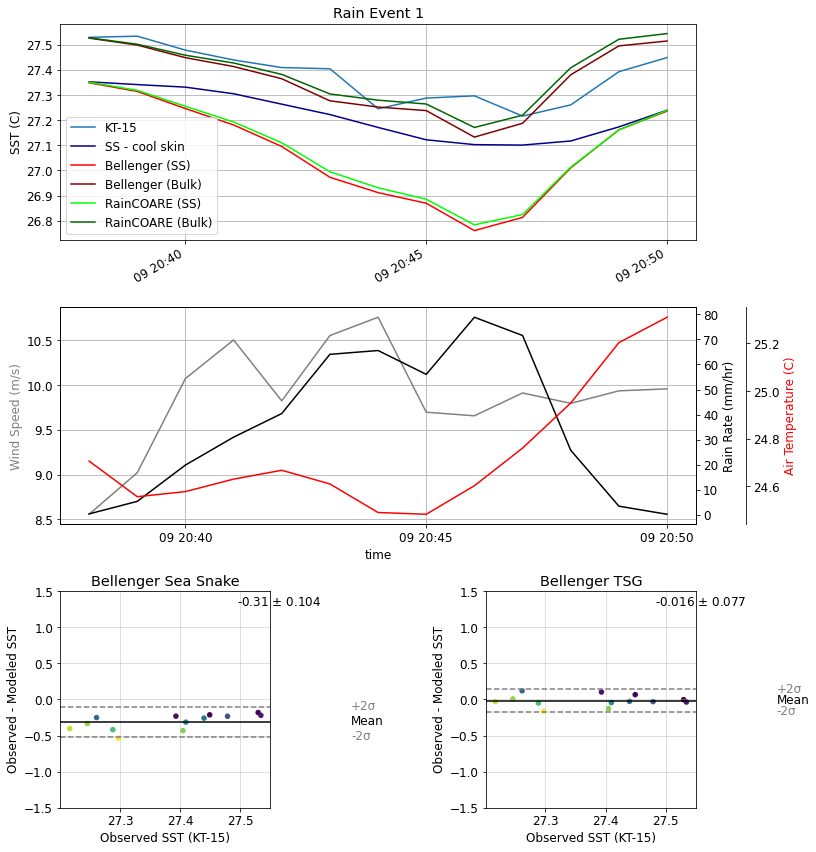

In [282]:
for event_num in tqdm.tqdm(np.arange(0,len(rain_event_list))):
    event = rain_event_list[event_num]
    #resample to 1min and fill in any missing gaps
    sst = sst_event_list[event_num].sst.resample(index='1min').mean().interp_like(event)
    sst = sst.where(np.isfinite(sst),drop=True).where(event.P != 0, drop=True)
    event = event.where(np.isfinite(sst),drop=True).where(event.P != 0, drop=True)

    #------------PLOT AND SAVE---------------------
    fig = plt.figure(figsize=(12,12))
    axx0 = plt.subplot2grid(shape=(3,2),loc=(0,0),rowspan=1,colspan=2)
    sst.plot(ax=axx0,color='C0')
    event.SST.plot(ax=axx0,color='darkblue')
    
    event.t_int_SS.plot(ax=axx0,color='red')
    event.t_int.plot(ax=axx0,color='maroon')
    
    event.SSTrain.plot(ax=axx0,color='lime')
    event.SSTrain_fromBulk.plot(ax=axx0,color='darkgreen')

    axx0.legend(['KT-15','SS - cool skin', 'Bellenger (SS)','Bellenger (Bulk)', 'RainCOARE (SS)', 'RainCOARE (Bulk)'])
    axx0.set_title(f'Rain Event {event_num+1}')
    axx0.grid()
    axx0.set_ylabel('SST (C)')
    axx0.set_xlabel('')

    axx1 = plt.subplot2grid(shape=(3,2),loc=(1,0),rowspan=1,colspan=2)
    
    axx1.plot(event.U10,'gray')
    axx1.grid()
    axx1.set_ylabel('Wind Speed (m/s)',color='gray')
    axx1.set_xlabel('time')

    par = axx1.twinx()
    par.plot(event.P,'k')
    par.set_ylabel('Rain Rate (mm/hr)')
    
    par12 = axx1.twinx()
    offset = 50
    par12.spines['right'].set_position(('outward',offset))
    par12.plot(event.T10,color='red')
    par12.set_ylabel('Air Temperature (C)',color='red')
    
    if event_num !=1:
        axx21 = plt.subplot2grid(shape=(3,2),loc=(2,0),rowspan=1,colspan=1)
        diff_plot(sst, event.t_int_SS, event.P, axis=axx21, cmap='viridis', marker='o', size=20)
        axx21.set_title('Bellenger Sea Snake')

        axx22 = plt.subplot2grid(shape=(3,2),loc=(2,1),rowspan=1,colspan=1)
        diff_plot(sst, event.t_int, event.P, axis=axx22, cmap='viridis', marker='o', size=20)
        axx22.set_title('Bellenger TSG')
    
        for axis in [axx21, axx22]:
            axis.set_ylabel('Observed - Modeled SST')
            axis.set_xlabel('Observed SST (KT-15)')
            axis.grid(alpha=0.5)
            axis.set_ylim([-1.5,1.5])

    
    plt.tight_layout()
    break
    plt.savefig(f'./Figures/Bellenger Model Eval/Individual Events - Both And/Event {event_num+1}.png')
    plt.close()
    

### Old Versions

In [300]:
num_list = []
time_list = []
sst_list = []
t_int_list = []
t_int_vF_list = []
t_int_SS_list = []
t_int_vF_SS_list = []

for event_num in np.arange(len(rain_event_list)):
    event = rain_event_list[event_num]
    #resample to 1min and fill in any missing gaps
    sst = sst_event_list[event_num].sst.resample(index='1min').mean().interp_like(event)
    sst = sst.where(np.isfinite(sst),drop=True).where(event.P != 0, drop=True)
    event = event.where(np.isfinite(sst),drop=True).where(event.P != 0, drop=True)
    
    num_list.append(event_num*np.ones_like(sst.values))
    time_list.append(event.index.values)
    sst_list.append(sst.values)
    t_int_list.append(event.t_int.values)
    t_int_vF_list.append(event.t_int_vF.values)
    t_int_SS_list.append(event.t_int_SS.values)
    t_int_vF_SS_list.append(event.t_int_vF_SS.values)
    
event_nums = np.concatenate(num_list)
time = np.concatenate(time_list)
sst = np.concatenate(sst_list)
t_int = np.concatenate(t_int_list)
t_int_vF = np.concatenate(t_int_vF_list)
t_int_SS = np.concatenate(t_int_SS_list)
t_int_vF_SS = np.concatenate(t_int_vF_SS_list)

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


NameError: name 'sst' is not defined

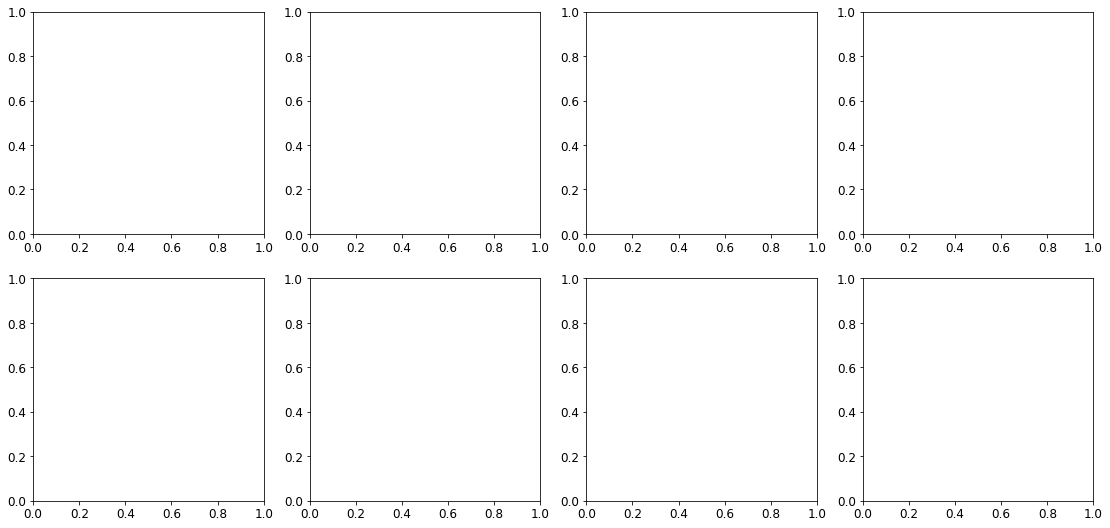

In [14]:
fig,axx = plt.subplots(figsize=(19,9), nrows=2, ncols=4)

cmap = None
marker = 'o'
size = 10

axx[0,0].scatter(sst, t_int_SS, s=size, cmap=cmap, marker=marker)
axx[0,1].scatter(sst, t_int_vF_SS, s=size, cmap=cmap, marker=marker)
axx[0,2].scatter(sst, t_int, s=size, cmap=cmap, marker=marker)
axx[0,3].scatter(sst, t_int_vF, s=size, cmap=cmap, marker=marker)

diff_plot(sst, t_int_SS, 'C0', axis=axx[1,0], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int_vF_SS, 'C0', axis=axx[1,1], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int, 'C0', axis=axx[1,2], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int_vF, 'C0', axis=axx[1,3], cmap=cmap, marker=marker, size=size)

axx[0,0].set_title('Modified Bellenger')
axx[0,1].set_title('Original Bellenger')
axx[0,2].set_title('Modified Bellenger')
axx[0,3].set_title('Original Bellenger')

plt.suptitle('Fed with Sea Snake Temperature (10cm depth)                                                     Fed with TSG Temperature (5m depth)',fontsize=18)#,y=0.95)
    
for axis in axx[0,:]:
    axis.grid(alpha=0.5,zorder=0)
    axis.plot(np.linspace(26,31),np.linspace(26,31),'k')
    axis.set_xlabel('Observed SST (KT-15)')
    axis.set_ylabel('Modeled SST')
    #axis.set_ylim([-2,0.25])
    
for axis in axx[1,:]:
    axis.set_ylabel('Modeled - Observed SST')
    axis.set_xlabel('Observed SST (KT-15)')
    axis.grid(alpha=0.5)
    axis.set_ylim([-1.5,1.5])

plt.tight_layout()

#plt.savefig('./Figures/Observed vs. Modeled SST rain data v1.png')

In [ ]:
fig,axx = plt.subplots(figsize=(34,9), nrows=2, ncols=7)

cmap = None
marker = 'o'
size = 10

axx[0,0].scatter(sst, t_int_SS, s=size, cmap=cmap, marker=marker)
axx[0,1].scatter(sst, t_int_vF_SS, s=size, cmap=cmap, marker=marker)
axx[0,2].scatter(sst, sst_raincoare_SS, s=size, cmap=cmap, marker=marker)
axx[0,3].scatter(sst, sst_coare, s=size, cmap=cmap, marker=marker)
axx[0,4].scatter(sst, t_int, s=size, c='C1', cmap=cmap, marker=marker)
axx[0,5].scatter(sst, t_int_vF, s=size, c='C1', cmap=cmap, marker=marker)
axx[0,6].scatter(sst, sst_raincoare, c='C1', s=size, cmap=cmap, marker=marker)

diff_plot(sst, t_int_SS, 'C0', axis=axx[1,0], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int_vF_SS, 'C0', axis=axx[1,1], cmap=cmap, marker=marker, size=size)
diff_plot(sst, sst_raincoare_SS, 'C0', axis=axx[1,2], cmap=cmap, marker=marker, size=size)
diff_plot(sst, sst_coare, 'C0', axis=axx[1,3], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int, 'C1', axis=axx[1,4], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int_vF, 'C1', axis=axx[1,5], cmap=cmap, marker=marker, size=size)
diff_plot(sst, sst_raincoare, 'C1', axis=axx[1,6], cmap=cmap, marker=marker, size=size)

axx[0,0].set_title('Modified Bellenger')
axx[0,1].set_title('Original Bellenger')
axx[0,2].set_title('Rain-Modified COARE')
axx[0,3].set_title('Standard COARE')
axx[0,4].set_title('Modified Bellenger')
axx[0,5].set_title('Original Bellenger')
axx[0,6].set_title('Rain-Modified COARE')


plt.suptitle('Fed with Sea Snake Temperature (10cm depth)                                                                                                     Fed with TSG Temperature (5m depth)',fontsize=20)#,y=0.95)
    
for axis in axx[0,:]:
    axis.grid(alpha=0.5,zorder=0)
    axis.plot(np.linspace(26,31),np.linspace(26,31),'k')
    axis.set_xlabel('Observed SST (KT-15)')
    axis.set_ylabel('Modeled SST')
    #axis.set_ylim([-2,0.25])
    
for axis in axx[1,:]:
    axis.set_ylabel('Modeled - Observed SST')
    axis.set_xlabel('Observed SST (KT-15)')
    axis.grid(alpha=0.5)
    axis.set_ylim([-1.5,1.5])

plt.tight_layout()

#plt.savefig('./Figures/Observed vs. Modeled SST rain data v2.png')

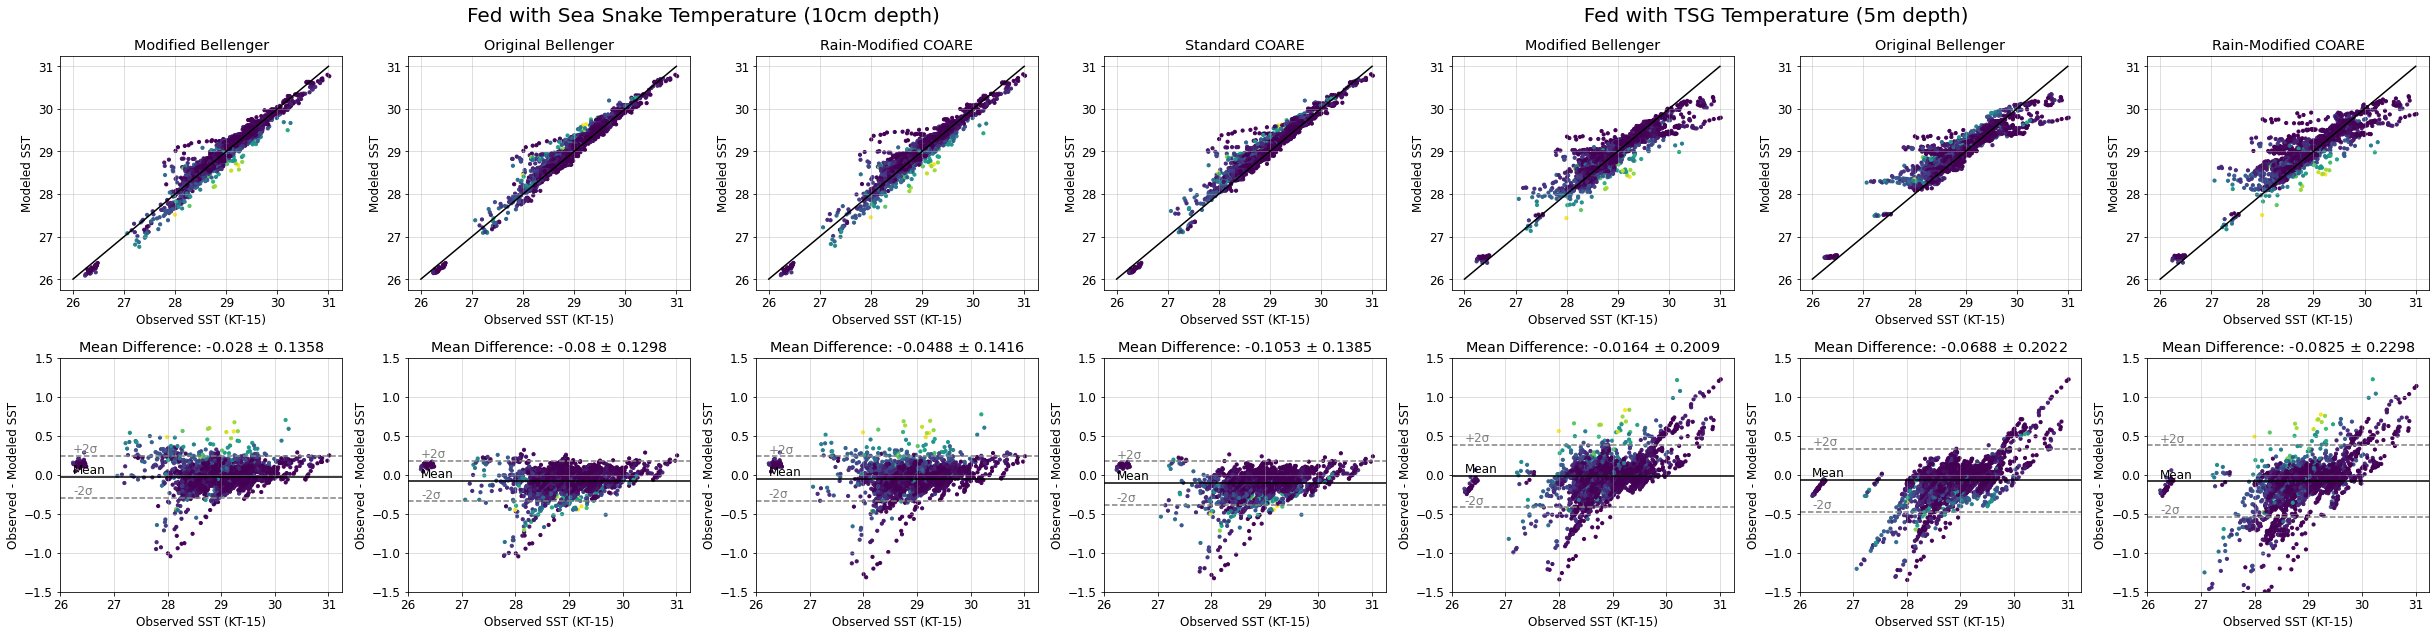

In [305]:
fig,axx = plt.subplots(figsize=(34,9), nrows=2, ncols=7)

cmap = None
marker = 'o'
size = 10

axx[0,0].scatter(sst, t_int_SS, s=size, c=p, cmap=cmap, marker=marker)
axx[0,1].scatter(sst, t_int_vF_SS, s=size, c=p, cmap=cmap, marker=marker)
axx[0,2].scatter(sst, sst_raincoare_SS, s=size, c=p, cmap=cmap, marker=marker)
axx[0,3].scatter(sst, sst_coare, s=size, c=p, cmap=cmap, marker=marker)
axx[0,4].scatter(sst, t_int, s=size, c=p, cmap=cmap, marker=marker)
axx[0,5].scatter(sst, t_int_vF, s=size, c=p, cmap=cmap, marker=marker)
axx[0,6].scatter(sst, sst_raincoare, c=p, s=size, cmap=cmap, marker=marker)

diff_plot(sst, t_int_SS, p, axis=axx[1,0], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int_vF_SS, p, axis=axx[1,1], cmap=cmap, marker=marker, size=size)
diff_plot(sst, sst_raincoare_SS, p, axis=axx[1,2], cmap=cmap, marker=marker, size=size)
diff_plot(sst, sst_coare, p, axis=axx[1,3], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int, p, axis=axx[1,4], cmap=cmap, marker=marker, size=size)
diff_plot(sst, t_int_vF, p, axis=axx[1,5], cmap=cmap, marker=marker, size=size)
diff_plot(sst, sst_raincoare, p, axis=axx[1,6], cmap=cmap, marker=marker, size=size)

axx[0,0].set_title('Modified Bellenger')
axx[0,1].set_title('Original Bellenger')
axx[0,2].set_title('Rain-Modified COARE')
axx[0,3].set_title('Standard COARE')
axx[0,4].set_title('Modified Bellenger')
axx[0,5].set_title('Original Bellenger')
axx[0,6].set_title('Rain-Modified COARE')


plt.suptitle('Fed with Sea Snake Temperature (10cm depth)                                                                                                     Fed with TSG Temperature (5m depth)',fontsize=20)#,y=0.95)
    
for axis in axx[0,:]:
    axis.grid(alpha=0.5,zorder=0)
    axis.plot(np.linspace(26,31),np.linspace(26,31),'k')
    axis.set_xlabel('Observed SST (KT-15)')
    axis.set_ylabel('Modeled SST')
    #axis.set_ylim([-2,0.25])
    
for axis in axx[1,:]:
    axis.set_ylabel('Observed - Modeled SST')
    axis.set_xlabel('Observed SST (KT-15)')
    axis.grid(alpha=0.5)
    axis.set_ylim([-1.5,1.5])

plt.tight_layout()

plt.savefig('./Figures/Observed vs. Modeled SST rain data v3.png')

## Diagnostic Stuff

In [206]:
%autoreload
from Ocean_Skin_Model import ocean_skin

In [207]:
%autoreload
from Ocean_Skin_Model import ocean_skin

TSG_depth = 0.1 #[m] depth of sea snake now - let's try 10cm instead of 5 for consistency with previous studies

# run Bellenger model without rain physics for full rv dataset

#------------SET UP MODEL INPUT-----------------    
U = rv.Ur10.values
T_fnd = rv.Tsea.values
T_air = rv.T10.values
q = rv.Q10.values/1000 # unit conversion g/kg -> kg/kg
rsds = -rv.Solardn.values
p = rv.Pair10.values
rain = rv.P.values
shf = rv.shf.values 
lhf = rv.lhf.values 
rln = rv.IRdn.values + rv.IRup.values #net IR, positive upwards
tau = rv.stress.values
s1 = rv.SalTSG.values
#initialize time as number of elapsed seconds from first timestep
time = (rv.index - rv.index[0]).values.astype(float) * 10**-9

#---------------RUN MODEL WITH RAIN OFF ("WARM")-------------------
[t_int_warm, s_int_warm, tkt_warm, tks_warm, dter_warm, dser_warm, dt_ns_warm, ds_ns_warm, rf_warm, taur_warm] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=False, rain_effect=False, fV_flag=False, spread_flag=False)


100%|████████████████████████████████████████████████████████████████████████| 134644/134644 [00:28<00:00, 4684.43it/s]


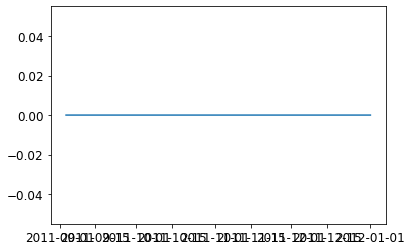

In [208]:
plt.plot(rv.index,dt_ns_warm)
#plt.ylim(-0.1,0)

Ok so dt_ns is always coming out negative when in the majority of cases it should be a positive quantity as usually the subskin temperature should be warmer than the foundation, particularly during the day. Need to figure out what is causing this. 

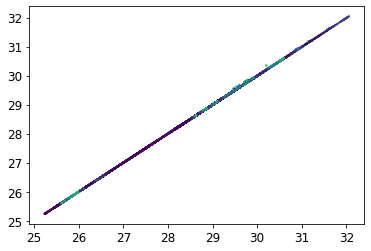

In [209]:
plt.scatter(rv.SST,t_int_warm, c=-rv.Solardn, s=1)

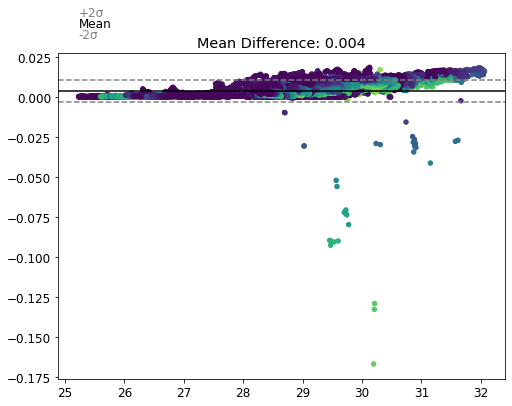

In [210]:
fig,axx=plt.subplots(figsize=(8,6))
diff_plot(rv.SST, t_int_warm, -rv.Solardn, axis=axx, cmap='viridis', marker='o', size=20)
#plt.ylim(-0.5,0.5)

Clear systematic relationship with divergence from agreement and solar insolation. Needed to put the solar downwelling value in as negative because it's given as negative values and they need to be positive!

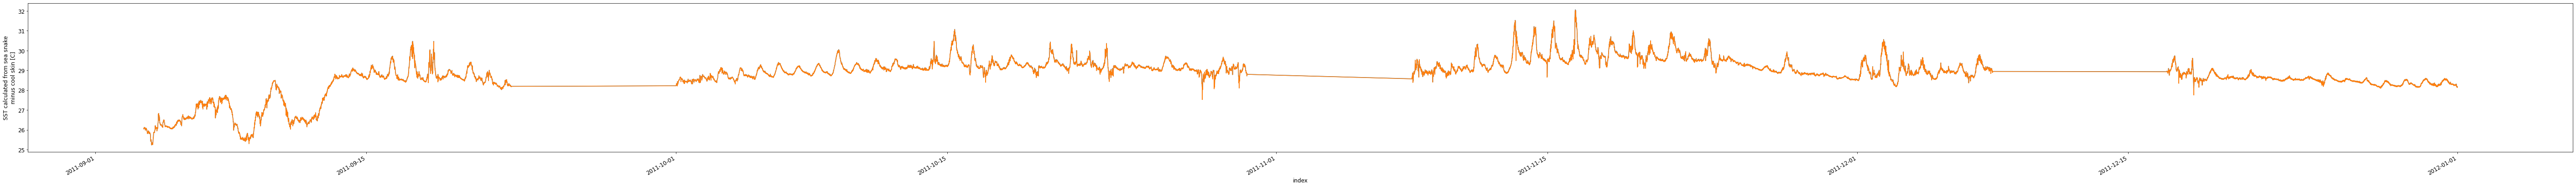

In [211]:
fig,axx=plt.subplots(figsize=(100,6))
rv.SST.plot()
plt.plot(rv.index, t_int_warm)

In [124]:
index_list = []
δsst_list = []
δt_int_list = []
δt_int_vF_list = []
δt_int_SS_list = []
δt_int_vF_SS_list = []

for event_num in composite_event.event:
    event = composite_event.sel(event = event_num, index=slice(0,2))
    index_list.append(event.index.values)
    δsst_list.append(event.δsst.values)
    δt_int_list.append(event.δt_int.values)
    δt_int_vF_list.append(event.δt_int_vF.values)
    δt_int_SS_list.append(event.δt_int_SS.values)
    δt_int_vF_SS_list.append(event.δt_int_vF_SS.values)
    
index = np.concatenate(index_list)
δsst = np.concatenate(δsst_list)
δt_int = np.concatenate(δt_int_list)
δt_int_vF = np.concatenate(δt_int_vF_list)
δt_int_SS = np.concatenate(δt_int_SS_list)
δt_int_vF_SS = np.concatenate(δt_int_vF_SS_list)


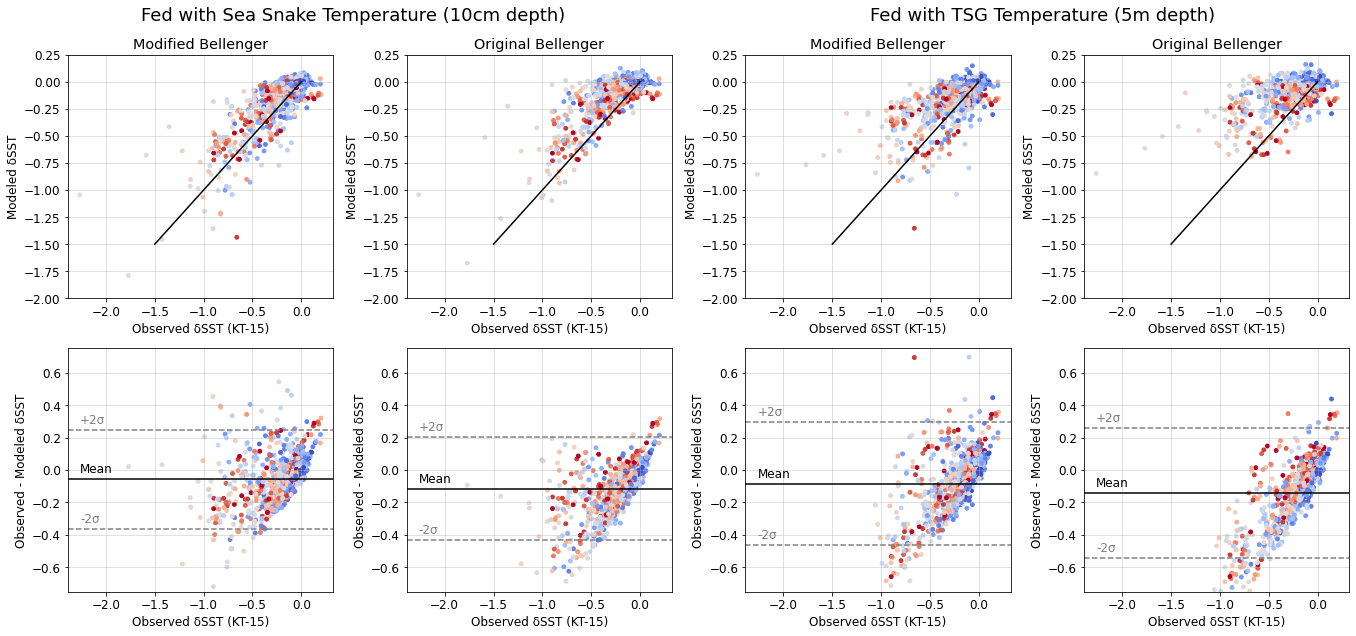

In [205]:
fig,axx = plt.subplots(figsize=(19,9), nrows=2, ncols=4)

cmap = 'coolwarm'
marker = 'o'
size = 15

axx[0,0].scatter(δsst, δt_int_SS, c=index, s=size, cmap=cmap, marker=marker)
axx[0,1].scatter(δsst, δt_int_vF_SS, c=index, s=size, cmap=cmap, marker=marker)
axx[0,2].scatter(δsst, δt_int, c=index, s=size, cmap=cmap, marker=marker)
axx[0,3].scatter(δsst, δt_int_vF, c=index, s=size, cmap=cmap, marker=marker)

diff_plot(δsst, δt_int_SS, index, axis=axx[1,0], cmap=cmap, marker=marker, size=size)
diff_plot(δsst, δt_int_vF_SS, index, axis=axx[1,1], cmap=cmap, marker=marker, size=size)
diff_plot(δsst, δt_int, index, axis=axx[1,2], cmap=cmap, marker=marker, size=size)
diff_plot(δsst, δt_int_vF, index, axis=axx[1,3], cmap=cmap, marker=marker, size=size)

axx[0,0].set_title('Modified Bellenger')
axx[0,1].set_title('Original Bellenger')
axx[0,2].set_title('Modified Bellenger')
axx[0,3].set_title('Original Bellenger')

plt.suptitle('Fed with Sea Snake Temperature (10cm depth)                                                     Fed with TSG Temperature (5m depth)',fontsize=18)#,y=0.95)
    
for axis in axx[0,:]:
    axis.grid(alpha=0.5,zorder=0)
    axis.plot(np.linspace(-1.5,0),np.linspace(-1.5,0),'k')
    axis.set_xlabel('Observed δSST (KT-15)')
    axis.set_ylabel('Modeled δSST')
    axis.set_ylim([-2,0.25])
    
for axis in axx[1,:]:
    axis.set_ylabel('Observed - Modeled δSST')
    axis.set_xlabel('Observed δSST (KT-15)')
    axis.grid(alpha=0.5)
    axis.set_ylim([-0.75,0.75])

plt.tight_layout()

plt.savefig('./Figures/Observed vs. Modeled deltaSST v2.png')

### Falkor 2019 SPIP Rain Event - do we want to try to run the model for this?

In [231]:
#open SPIP and Shipboard datasets
spip = xr.open_dataset('../../2019 Falkor/Data/SPIP2_Falkor19_BlessedDataset.nc')
spip2 = spip.sel(Time = spip.Station==2)
falkor = xr.open_dataset('../../2019 Falkor/Data/SHIP_Falkor19_BlessedDataset.nc').sel(Time=spip2.Time)
falkor

<xarray.Dataset>
Dimensions:              (Time: 26401)
Coordinates:
  * Time                 (Time) datetime64[ns] 2019-11-21T20:40:00 ... 2019-11-22T04:00:00
    Station              (Time) int32 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
Data variables:
    RelWindDir-FM        (Time) float64 ...
    RelWindSpd-FM        (Time) float64 ...
    AirPres-FM           (Time) float64 ...
    RelHum-FM            (Time) float64 ...
    AirTemp-FM           (Time) float64 ...
    Dewpoint-FM          (Time) float64 ...
    RelWindDir-PMM       (Time) float64 ...
    RelWindSpd-PMM       (Time) float64 ...
    AirPres-PMM          (Time) float64 ...
    RelHum-PMM           (Time) float64 ...
    AirTemp-PMM          (Time) float64 ...
    Dewpoint-PMM         (Time) float64 ...
    RelWindDir-SMM       (Time) float64 ...
    RelWindSpd-SMM       (Time) float64 ...
    AirPres-SMM          (Time) float64 ...
    RelHum-SMM           (Time) float64 ...
    AirTemp-SMM          (Time) float64 

In [232]:
spip2.AbsHum

<xarray.DataArray 'AbsHum' (Time: 26401)>
array([22.44, 22.41, 22.41, ..., 21.92, 21.92, 21.92])
Coordinates:
  * Time       (Time) datetime64[ns] 2019-11-21T20:40:00 ... 2019-11-22T04:00:00
    Latitude   (Time) float64 ...
    Longitude  (Time) float64 ...
    Station    (Time) int32 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
Attributes:
    units:      g/kg
    long_name:  Absolute Humidity (Maximet)

In [ ]:
%autoreload
from Ocean_Skin_Model import ocean_skin

TSG_depth = 0.6 #[m] depth of seabird

# run modified (& regular) Bellenger model for each rain event and add the outputs to the rain_event_list

#------------SET UP MODEL INPUT-----------------
event = rain_event_list[event_num]

U = spip2.WindSpd.values
T_fnd = spip2.T_190cm.values
T_air = spip2.AirTemp.values
q = spip2.AbsHum.values/1000 # unit conversion g/kg -> kg/kg
rsds = spip2.SolarRad.values
p = spip2.AirPres.values
rain = spip2.Precip.values
shf = event.shf.values 
lhf = event.lhf.values 
rln = event.IRdn.values + event.IRup.values #net IR, positive upwards
tau = event.stress.values
s1 = event.SalTSG.values
#initialize time as number of elapsed seconds from first timestep
time = (event.index - event.index[0]).values.astype(float) * 10**-9

#---------------RUN MODEL WITH VOLUME FRACTION ON-------------------
model_vF = pd.DataFrame(index=event.index.values)
[t_int_vF, s_int_vF, tkt_vF, tks_vF, dter_vF, dser_vF, dt_ns_vF, ds_ns_vF, rf_vF, taur_vF] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=True, spread_flag=True)

#---------------RUN MODEL WITH VOLUME FRACTION OFF------------------
model = pd.DataFrame(index=event.index.values)
[t_int, s_int, tkt, tks, dter, dser, dt_ns, ds_ns, rf, taur] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=False, spread_flag=True)

#---------------ASSIGN OUTPUT PARAMETERS TO RAIN EVENT--------------
rain_event_list[event_num]['t_int_vF_SS'] = ('index', t_int_vF)
rain_event_list[event_num]['s_int_vF_SS'] = ('index', s_int_vF)
rain_event_list[event_num]['tkt_vF_SS'] = ('index', tkt_vF)
rain_event_list[event_num]['tks_vF_SS'] = ('index', tks_vF)
rain_event_list[event_num]['dter_vF_SS'] = ('index', dter_vF)
rain_event_list[event_num]['dser_vF_SS'] = ('index', dser_vF)
rain_event_list[event_num]['dt_ns_vF_SS'] = ('index', dt_ns_vF)
rain_event_list[event_num]['ds_ns_vF_SS'] = ('index', ds_ns_vF)
rain_event_list[event_num]['rf_vF_SS'] = ('index', rf_vF)
rain_event_list[event_num]['taur_vF_SS'] = ('index', taur_vF)

rain_event_list[event_num]['t_int_SS'] = ('index', t_int)
rain_event_list[event_num]['s_int_SS'] = ('index', s_int)
rain_event_list[event_num]['tkt_SS'] = ('index', tkt)
rain_event_list[event_num]['tks_SS'] = ('index', tks)
rain_event_list[event_num]['dter_SS'] = ('index', dter)
rain_event_list[event_num]['dser_SS'] = ('index', dser)
rain_event_list[event_num]['dt_ns_SS'] = ('index', dt_ns)
rain_event_list[event_num]['ds_ns_SS'] = ('index', ds_ns)
rain_event_list[event_num]['rf_SS'] = ('index', rf)
rain_event_list[event_num]['taur_SS'] = ('index', taur)

#### Notes on Bellenger Model Modifications:
- Gosnell heat flux was being calculated incorrectly/inconsistent with COARE. Modified to be consistent with COARE.
- Removed volume fraction calculation from interfacial heat flux used in skin correction

# Supplementary Material

### Raindrop Obstruction of the Radiometer Optical Path

For our KT15.82 Detector Type A Lens K6

In [44]:
R = 20 #[mm/hr] rain rate

h = 5 #[m], vertical freeboard of radiometer (currently guessing)
θ = 30 #[degrees], angle from vertical of radiometer
l = h/np.cos(np.deg2rad(θ))
l*1000

5773.502691896258

In [92]:
#read spot diameter off of KT15 chart for that distance
D = 150 #mm, should end up somewhere between 100 and 200 mm depending on which detector type we have and the exact freeboard
#calculate volume of observation cone
A = np.pi*(D/1000/2)**2 # [m^2] area of cone base (convert mm->m and diameter->radius)
V = (l/3)*A #[m^3] volume of cone

#Raindrop size distribution based on rain rate
R = 25 #[mm/hr] rain rate
r = np.linspace(0.0005, 0.0025, num=100) #[m] #vector of possible drop radii from 1mm to 5mm
Λ = -41*100*(R**-0.21) #[1/m]
n = (0.08*1e8)*np.exp(Λ*r*2) #[m-3 m-1] number of drops in the volume at a certain radius (*2 because originally formulated in terms of diameter)

#DSD -> obscured area
area_per_r = np.pi*(r**2)*V*n
total_area = np.trapz(area_per_r, r)

total_area/A

0.0008686168599839131

In [95]:
def obscured_area(R, l, D):
    '''
    Calculate percentage of radiometer spot area obscured by raindrops in the optical path. 
    Naive calculation assuming no raindrops are behind one another, ie every single drop is blocking additional photons. Thus gives a high bound for the amount of blocked area possible. 
    
    Inputs:
        R - [mm/hr] rain rate
        l - [m] path length between radiometer lens and target
        D - [m] diameter of radiometer spot at this path length
        
    Outputs:
        O - Ratio between obscured area and total area
    '''
    #calculate volume of observation cone
    A = np.pi*(D/2)**2 # [m^2] area of cone base (convert diameter->radius)
    V = (l/3)*A #[m^3] volume of cone

    #Raindrop size distribution based on rain rate
    r = np.linspace(0, 0.005, num=200) #[m] #vector of possible drop radii up to 5mm
    Λ = -41*100*(R**-0.21) #[1/m]
    n = (0.08*1e8)*np.exp(Λ*r*2) #[m-3 m-1] number of drops in the volume at a given radius (*2 because originally formulated in terms of diameter)

    #convert size distribution -> obscured area
    area_per_r = np.pi*(r**2)*V*n #[m^2 m-1] obscured area at a given radius
    rain_area = np.trapz(area_per_r, r) #total obscured area integrated across all radii

    return rain_area/A

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in power
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


Text(0.5, 1.0, 'Obscuring of Radiometer Spot Area by Falling Raindrops')

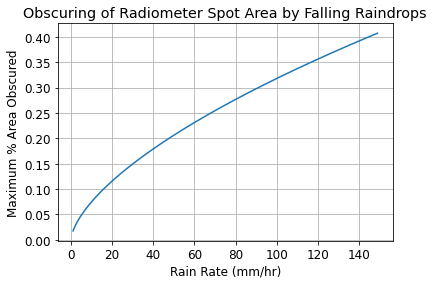

In [103]:
h = 5 #[m], vertical freeboard of radiometer (approximate)
θ = 30 #[degrees], angle from vertical of radiometer (approximate)
l = h/np.cos(np.deg2rad(θ))
#read spot diameter off of KT15 chart for that distance
D = 0.150 #[m], should end up somewhere between 100 and 200 mm depending on which detector type we have and the exact freeboard

rains = np.arange(0,150)
ratios = []

for R in rains:
    ratios.append(obscured_area(R, l, D)*100)
    
plt.plot(rains, ratios)
plt.ylabel('Maximum % Area Obscured')
plt.xlabel('Rain Rate (mm/hr)')
plt.grid()
plt.title('Obscuring of Radiometer Spot Area by Falling Raindrops')

#### Need to think a little bit more about the importance of distance from the sensor... ie the same size raindrop will obscure much more of the area if it is close to the sensor.

In [ ]:
#more complex formulation (Veron & Miussens, 2016) - not currently working
#R_ms = R/1000*3600    #[mm/hr] -> [m/s]
#Λ = 344.34*R_ms**(-0.21) #[1/m], R must be in m/s
#Yw = 9.32 #[m/s]
#αw = 1296 #[1/m]
#n = R_ms*np.exp(-Λ*r)/(8*np.pi*Yw)*(((Λ + αw)**-4) - (Λ**-4))**-1

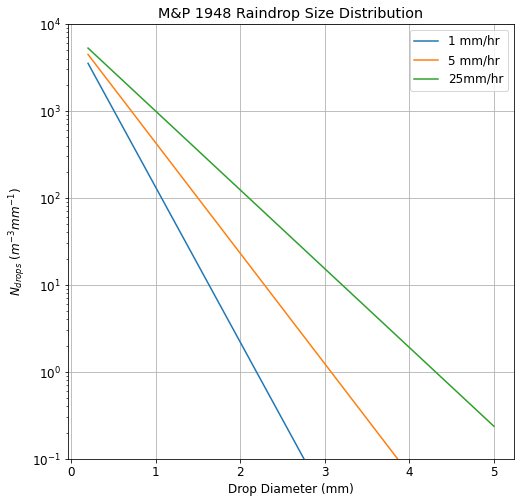

In [89]:
#RECREATING M&P 48 FIGURE 2 FOR COMPLETENESS
D = 150 #mm, should end up somewhere between 100 and 200 mm depending on which detector type we have and the exact freeboard
#Raindrop size distribution based on rain rate
R = 25 #[mm/hr] rain rate
r = np.linspace(0.0001, 0.0025, num=100) #[m] #vector of possible drop radii from 1mm to 5mm

plt.figure(figsize=(8,8))

for R in [1,5,25]:
    Λ = -41*100*(R**-0.21) #[1/m]
    n = (0.08*1e5)*np.exp(Λ*r*2) #drop size distribution with radius (*2 because originally formulated in terms of diameter)
    plt.semilogy(r*2*1000, n)

plt.legend(['1 mm/hr','5 mm/hr', '25mm/hr'])
plt.title('M&P 1948 Raindrop Size Distribution')
plt.xlabel('Drop Diameter (mm)')
plt.ylabel('$N_{drops}$ $(m^{-3} mm^{-1})$')
plt.ylim([10**-1, 10**4])
plt.grid()

This is a nice replication of Figure 2 from Marshall & Palmer 1948.

## Rain Event Selection Criteria Sensitivity Analysis

## Comparing Bellenger without Rain to COARE3.5

In [235]:
rv

<xarray.Dataset>
Dimensions:    (index: 134644)
Coordinates:
  * index      (index) datetime64[ns] 2011-09-03T12:00:00 ... 2012-01-01
Data variables:
    COG        (index) float64 ...
    E          (index) float64 ...
    Evap       (index) float64 ...
    Heading    (index) float64 ...
    IRdn       (index) float64 ...
    IRup       (index) float64 ...
    Lat        (index) float64 ...
    Lon        (index) float64 ...
    P          (index) float64 ...
    Pair10     (index) float64 ...
    Precip     (index) float64 ...
    Q02        (index) float64 ...
    Q10        (index) float64 ...
    Qsea       (index) float64 ...
    RH02       (index) float64 ...
    RH10       (index) float64 ...
    SOG        (index) float64 ...
    SSQ        (index) float64 ...
    SST        (index) float64 ...
    SalTSG     (index) float64 ...
    Sclr       (index) float64 ...
    Smax       (index) float64 ...
    Solardn    (index) float64 ...
    Solarup    (index) float64 ...
    T02   

In [236]:
%autoreload
from Ocean_Skin_Model import ocean_skin

TSG_depth = 0.1 #[m] depth of sea snake now - let's try 10cm instead of 5 for consistency with previous studies

# run Bellenger model without rain or warm layer physics for full rv dataset

#------------SET UP MODEL INPUT-----------------    
U = rv.Ur10.values
T_fnd = rv.Tsea.values
T_air = rv.T10.values
q = rv.Q10.values/1000 # unit conversion g/kg -> kg/kg
rsds = rv.Solardn.values
p = rv.Pair10.values
rain = rv.P.values
shf = rv.shf.values 
lhf = rv.lhf.values 
rln = rv.IRdn.values + rv.IRup.values #net IR, positive upwards
tau = rv.stress.values
s1 = rv.SalTSG.values
#initialize time as number of elapsed seconds from first timestep
time = (rv.index - rv.index[0]).values.astype(float) * 10**-9

#---------------RUN MODEL WITH RAIN AND WARMLAYER OFF ("BASE")-------------------
[t_int_base, s_int_base, tkt_base, tks_base, dter_base, dser_base, dt_ns_base, ds_ns_base, rf_base, taur_base] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=False, rain_effect=False, fV_flag=False, spread_flag=False)



100%|████████████████████████████████████████████████████████████████████████| 134644/134644 [01:12<00:00, 1849.91it/s]


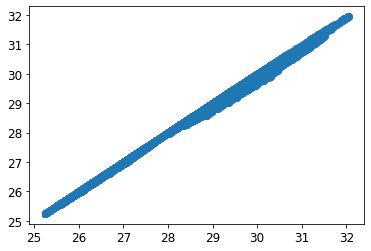

In [237]:
plt.scatter(rv.SST,t_int_base)

In [244]:
%autoreload
from Ocean_Skin_Model import ocean_skin

TSG_depth = 0.05 #[m] depth of sea snake now - let's try 10cm instead of 5 for consistency with previous studies

# run Bellenger model without rain physics for full rv dataset

#------------SET UP MODEL INPUT-----------------    
U = rv.Ur10.values
T_fnd = rv.Tsea.values
T_air = rv.T10.values
q = rv.Q10.values/1000 # unit conversion g/kg -> kg/kg
rsds = rv.Solardn.values
p = rv.Pair10.values
rain = rv.P.values
shf = rv.shf.values 
lhf = rv.lhf.values 
rln = rv.IRdn.values + rv.IRup.values #net IR, positive upwards
tau = rv.stress.values
s1 = rv.SalTSG.values
#initialize time as number of elapsed seconds from first timestep
time = (rv.index - rv.index[0]).values.astype(float) * 10**-9

#---------------RUN MODEL WITH RAIN OFF ("WARM")-------------------
[t_int_warm, s_int_warm, tkt_warm, tks_warm, dter_warm, dser_warm, dt_ns_warm, ds_ns_warm, rf_warm, taur_warm] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=False, fV_flag=False, spread_flag=False)


100%|████████████████████████████████████████████████████████████████████████| 134644/134644 [01:24<00:00, 1597.21it/s]


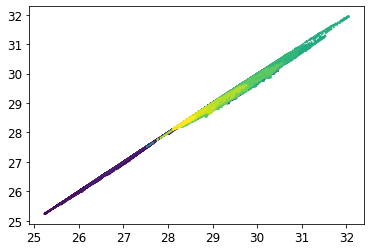

In [243]:
plt.scatter(rv.SST,t_int_warm, c=rv.index, s=1)

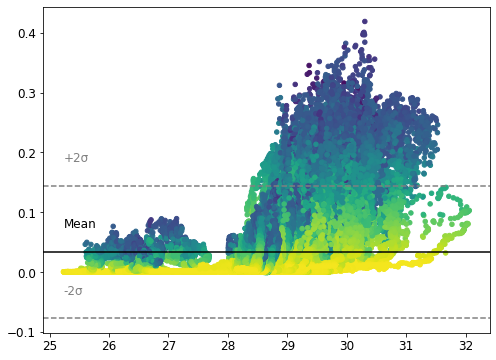

In [253]:
fig,axx=plt.subplots(figsize=(8,6))
diff_plot(rv.SST, t_int_base, rv.Solardn, axis=axx, cmap='viridis', marker='o', size=20)


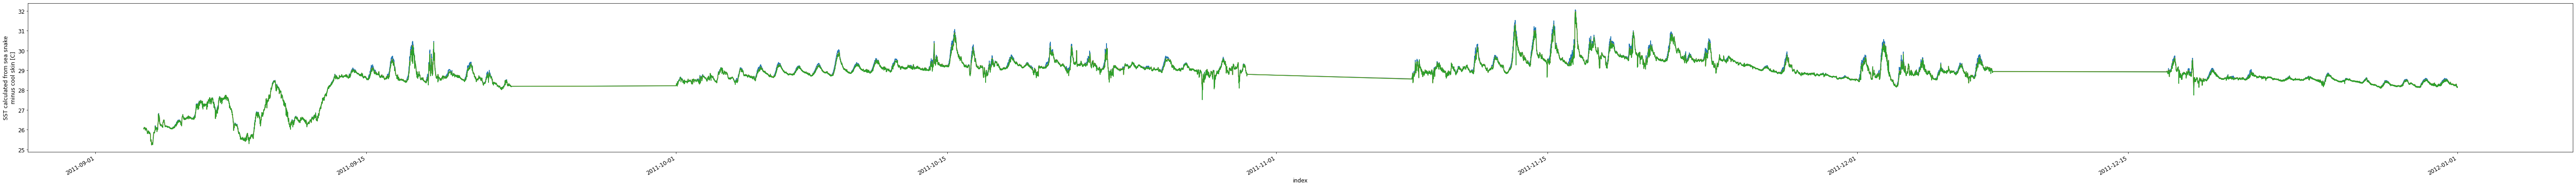

In [257]:
fig,axx=plt.subplots(figsize=(100,6))
rv.SST.plot()
plt.plot(rv.index, t_int_base)
plt.plot(rv.index, t_int_warm)

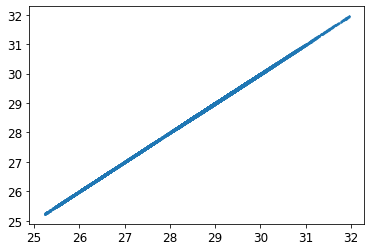

In [259]:
plt.scatter(t_int_base, t_int_warm, s=1)

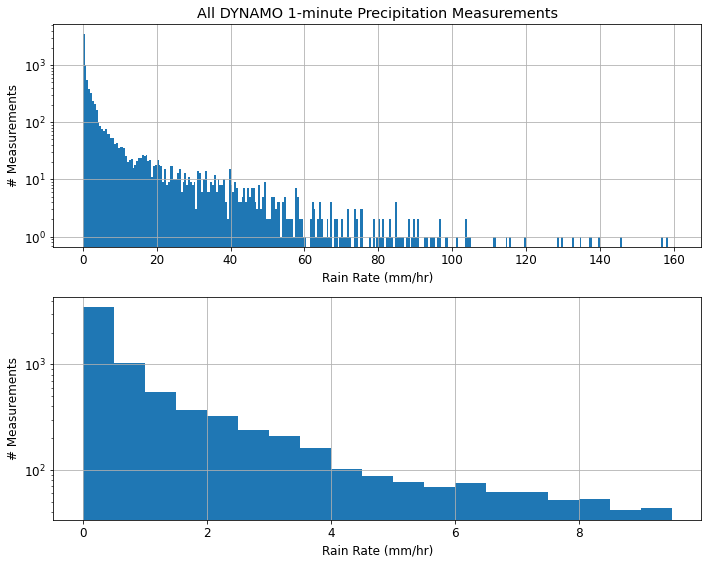

In [376]:
fig,axx = plt.subplots(nrows=2, facecolor='w',figsize=(10,8))

nonzeroP = rv.P.where(rv.P>0)

axx[0].hist(nonzeroP,bins=np.linspace(0,159.5,160*2),log=True)

axx[0].set_title('All DYNAMO 1-minute Precipitation Measurements')
axx[0].set_xlabel('Rain Rate (mm/hr)')
axx[0].set_ylabel('# Measurements')
axx[0].grid()
#axx[0].set_xlim([0,10])

axx[1].hist(nonzeroP,bins=np.linspace(0,9.5,20),log=True)
axx[1].set_xlabel('Rain Rate (mm/hr)')
axx[1].set_ylabel('# Measurements')
axx[1].grid()


plt.tight_layout()

plt.savefig('./Figures/Nonzero Rain Histogram v1.png', dpi=300)